Improvement notes:
- good exmple for multiple possible rulesets, that would equally well explain the instances classified $(1,0)$, because they are so close to the decision boundary, that small changes in any feature flip the predictions. with the features ordered by importance, it is clear to get a single order

In [9]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from comparers import ModelComparer
from util import RuleClassifier, get_complexity, evaluate_counterfactual_fidelity
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances,\
                       estimate_feature_interaction_order, print_rules
from clustering import make_clustering, plot_joint_feature_dependence, compare_indiv_dep_plots
from tasks.boston_housing import make_task4 as make_task
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from shap.plots import bar
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

# Setup Task

In [2]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [3]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [6]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact', explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact', explanation_type='mclass_diff', space_type='log_odds')
with open('indiv.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 247it [01:44,  2.23it/s]                         
Exact explainer: 247it [01:39,  2.22it/s]                         
Exact explainer: 247it [07:25,  1.86s/it]                         

CPU times: user 12min 7s, sys: 2min 13s, total: 14min 20s
Wall time: 10min 50s


# Traditional SHAP Explanations

In [3]:
with open('indiv.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

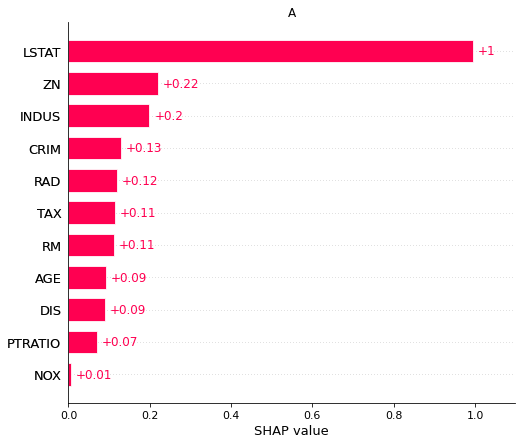

In [4]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, ['A.0', 'A.1', 'A.2']])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

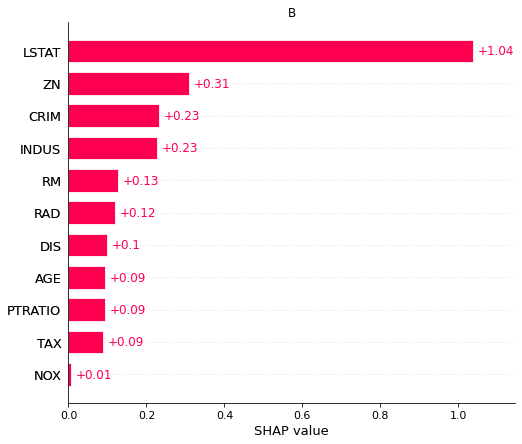

In [5]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, ['B.0', 'B.1', 'B.2']])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [6]:
feature_order, _ = calc_feature_order(indiv_shap_values)

In [7]:
node = make_clustering(comparer, indiv_shap_values, categorical_features=categorical_features)

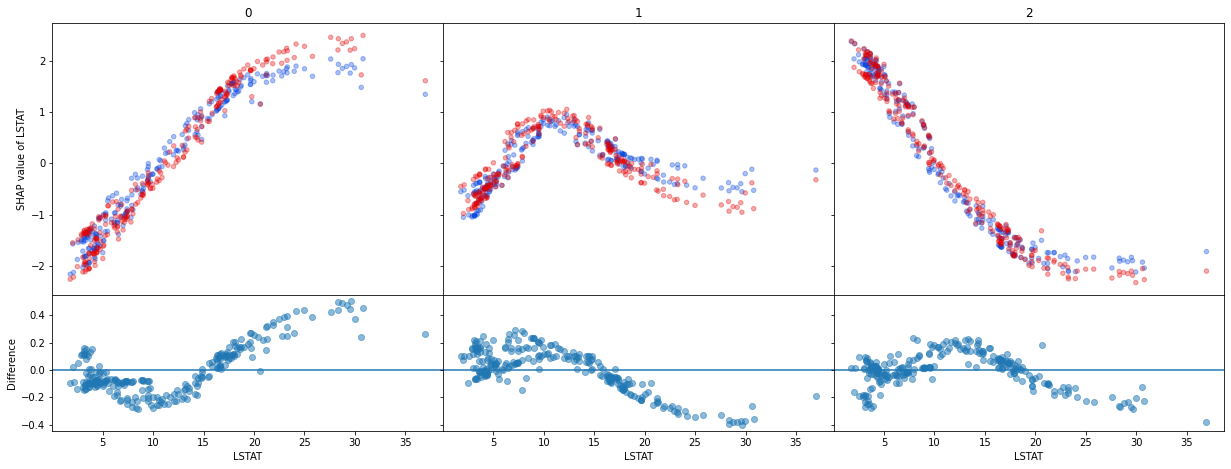

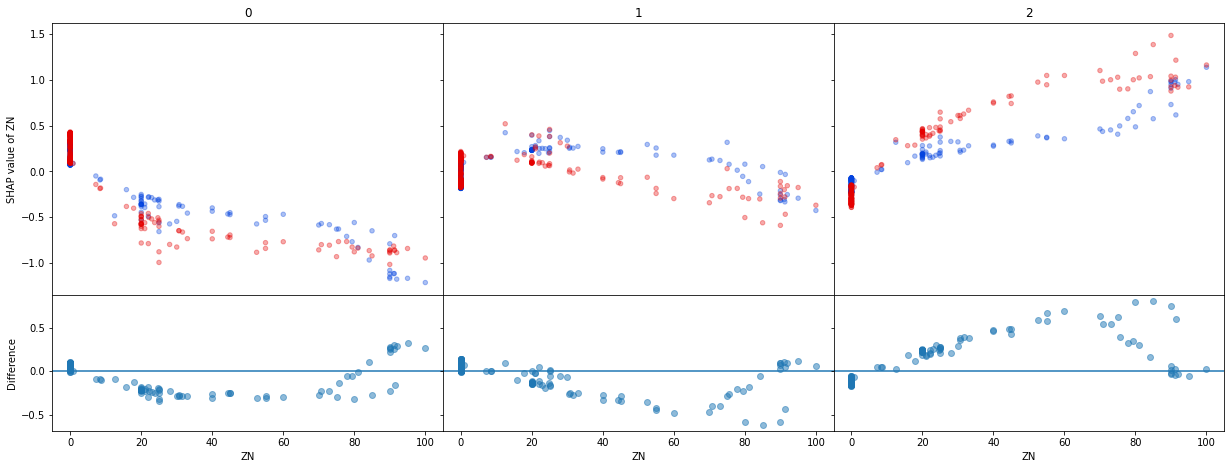

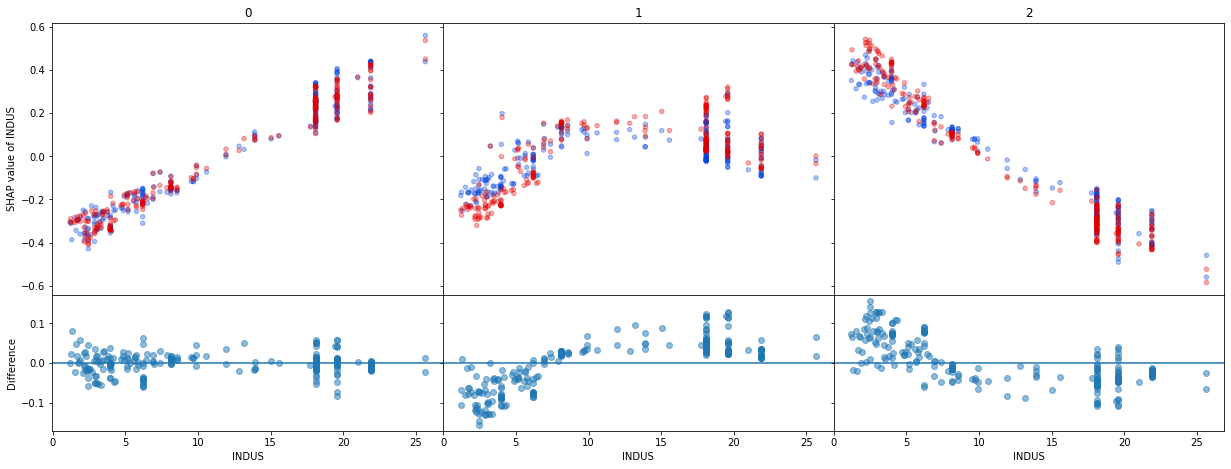

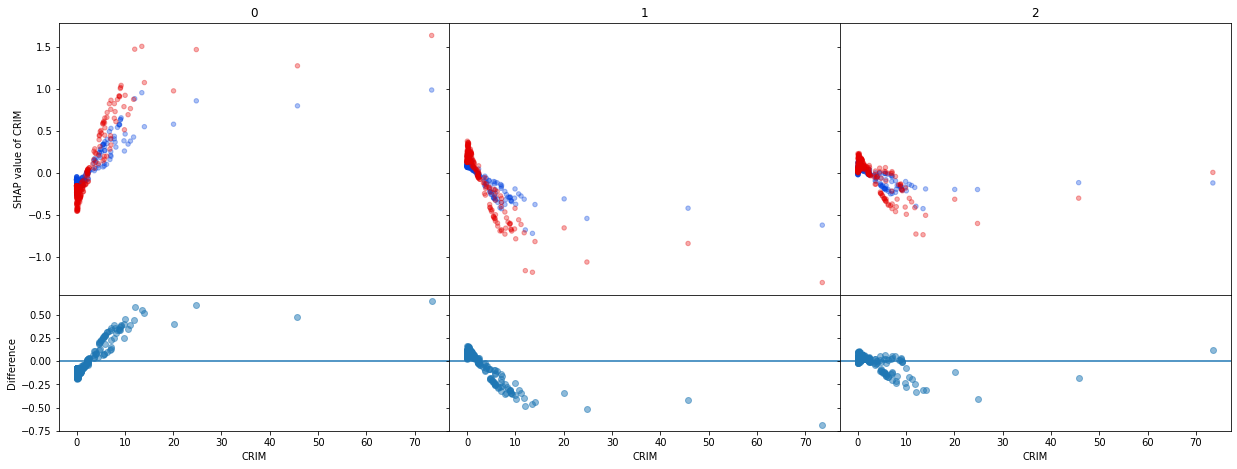

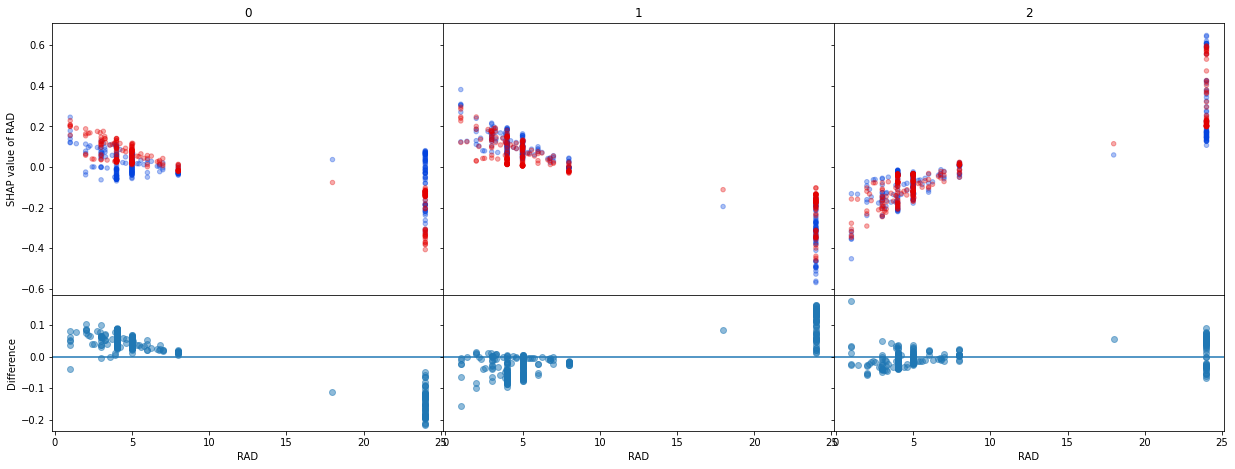

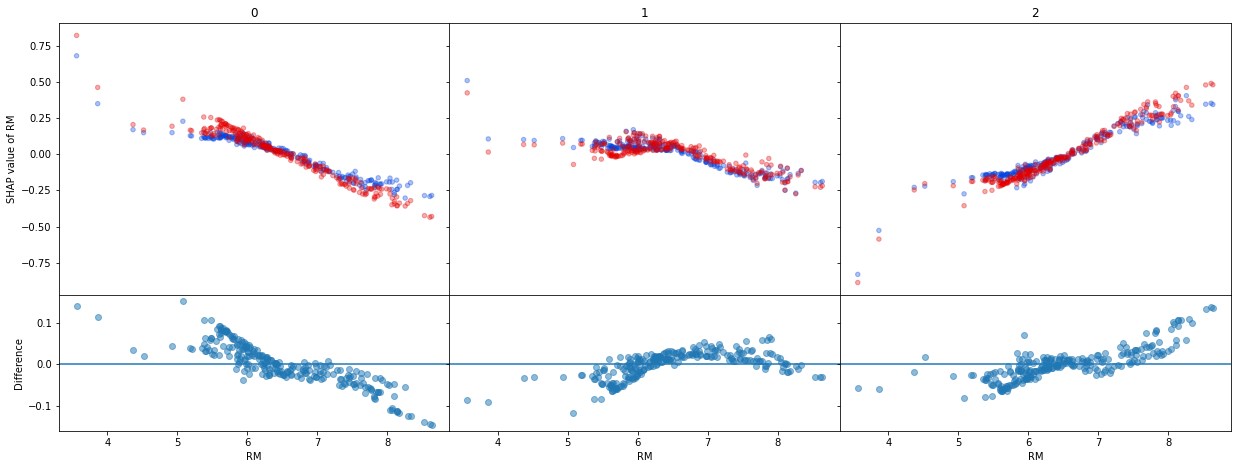

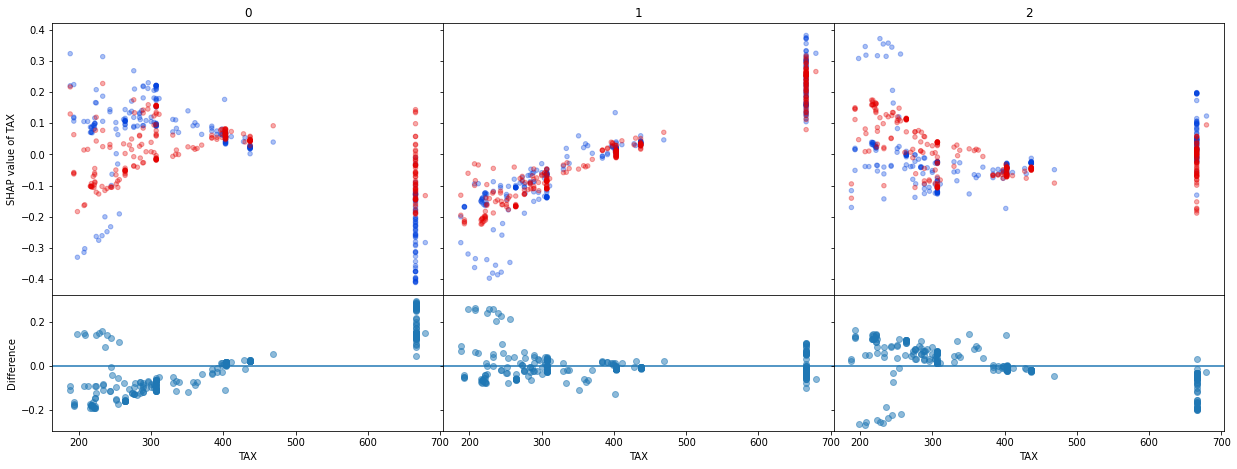

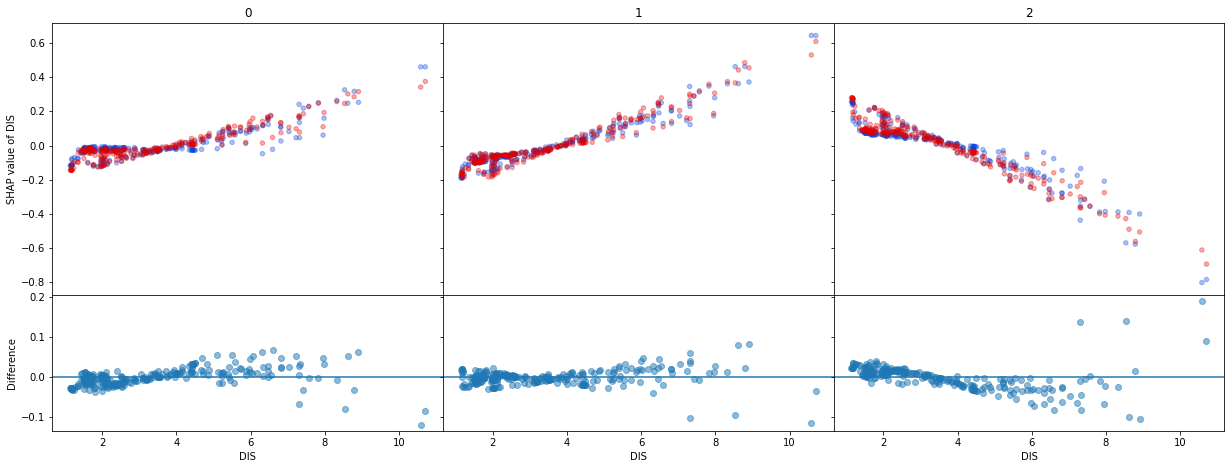

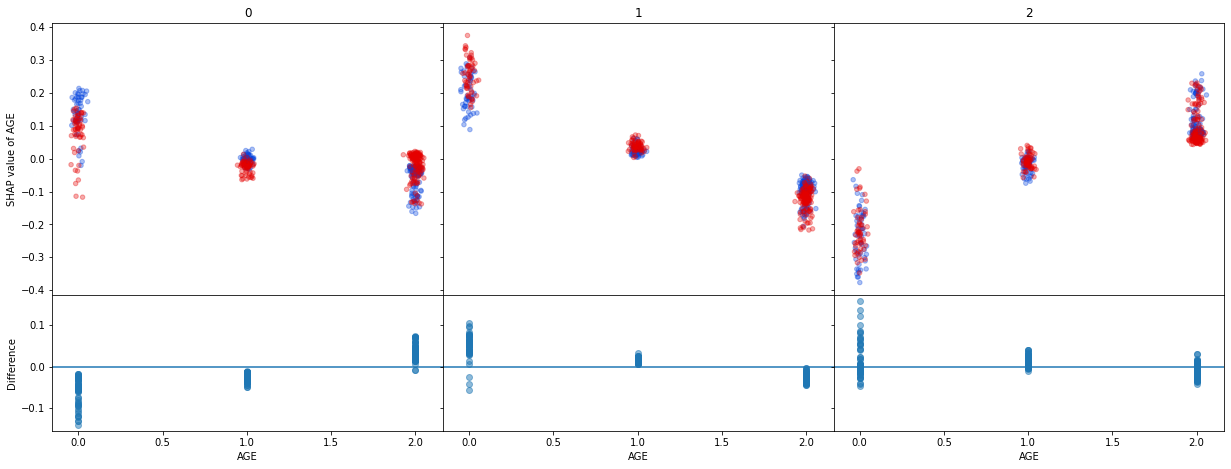

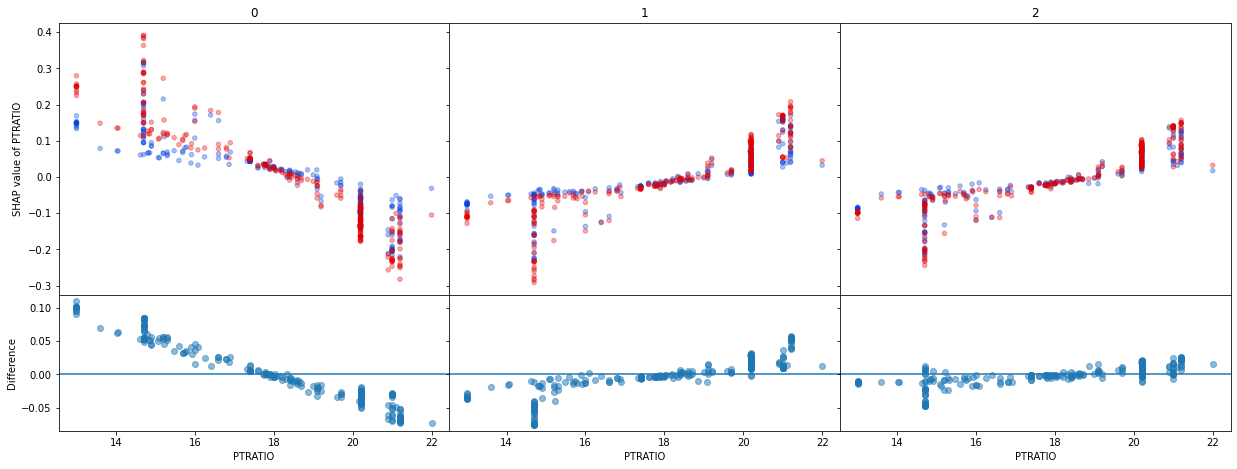

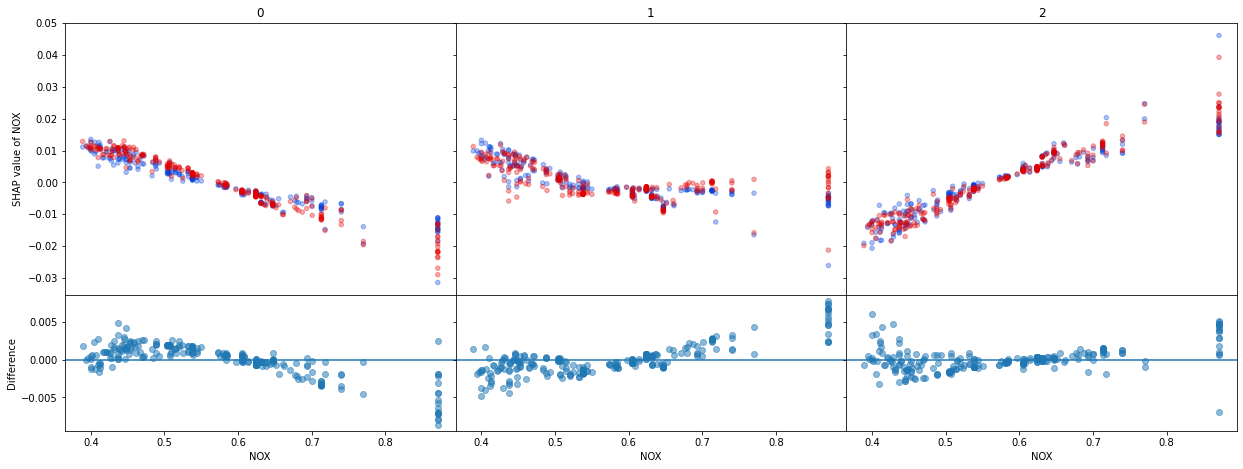

In [10]:
for feature in node.features_ordered:
    compare_indiv_dep_plots(node, feature)
    plt.show()

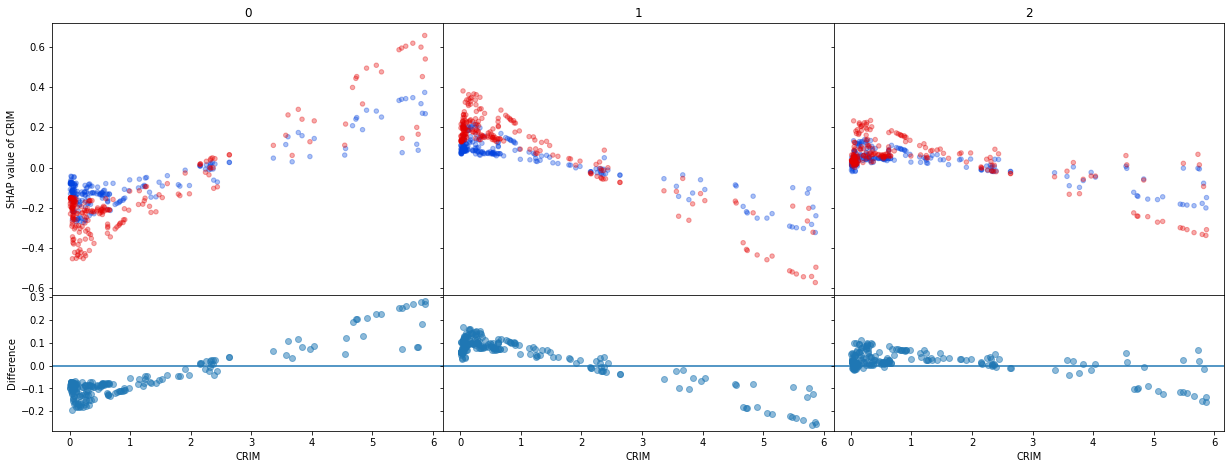

In [14]:
compare_indiv_dep_plots(node.filter('CRIM < 6'), 'CRIM')

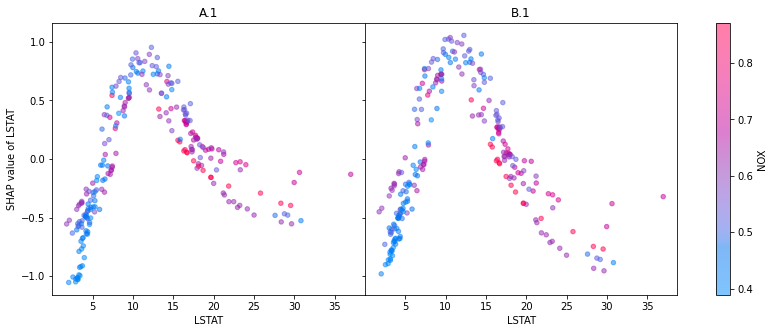

In [45]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'A.1'], 'LSTAT')
node.plot_feature_dependence('LSTAT', classes=['A.1', 'B.1'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

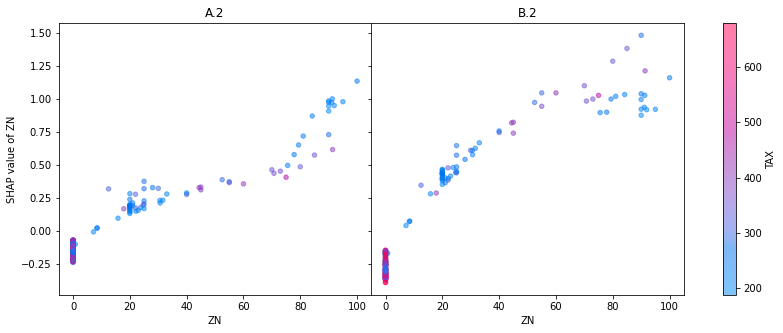

In [73]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'B.2'], 'ZN')
node.plot_feature_dependence('ZN', classes=['A.2', 'B.2'], alpha=0.5,
                             color='TAX')

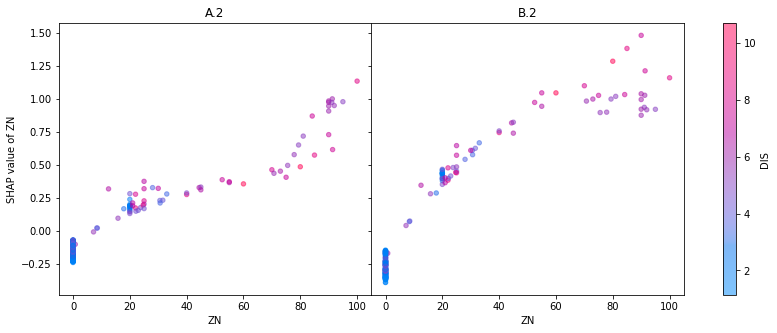

In [71]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'B.2'], 'ZN')
node.plot_feature_dependence('ZN', classes=['A.2', 'B.2'], alpha=0.5,
                             color='DIS')

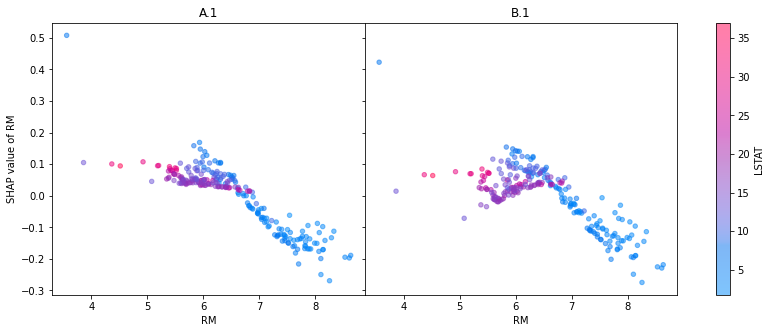

In [47]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'B.1'], 'RM')
node.plot_feature_dependence('RM', classes=['A.1', 'B.1'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

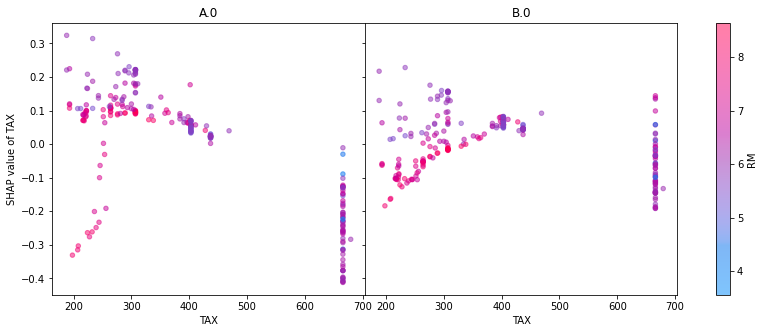

In [27]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'B.0'], 'TAX')
node.plot_feature_dependence('TAX', classes=['A.0', 'B.0'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

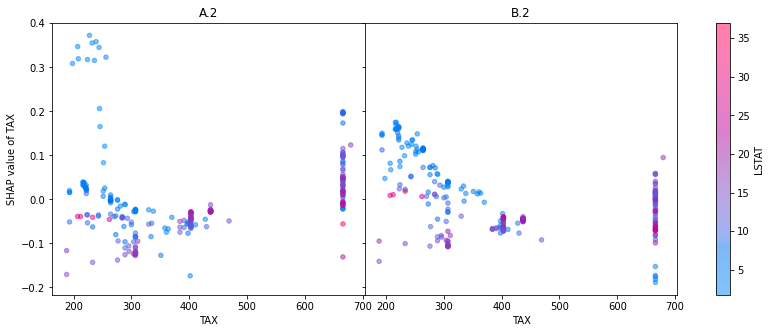

In [28]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'B.2'], 'TAX')
node.plot_feature_dependence('TAX', classes=['A.2', 'B.2'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

The vertical spread in the dependence plots of DIS suggests that interactions are present, but more important it looks like the interactions cause different DIS effects.

The SHAP package can estimate interactions based on correlation.

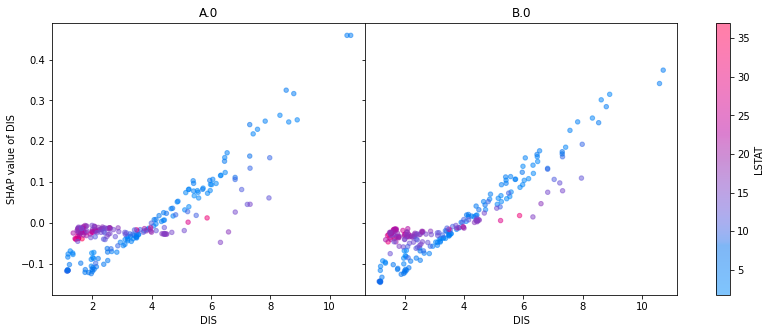

In [49]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'A.0'], 'DIS')
node.plot_feature_dependence('DIS', classes=['A.0', 'B.0'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

The strongest interactions are with feature LSTAT, clearly instances with medium to high LSTAT values yield different effects of feature DIS than with low values.

For AGE too, LSTAT mainly accounts for the vertical spread.

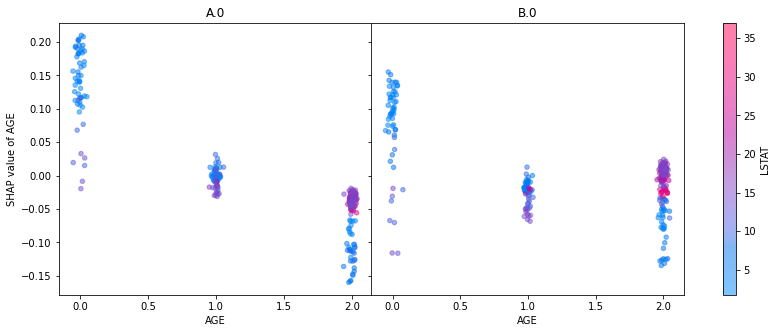

In [26]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'B.0'], 'AGE')
node.plot_feature_dependence('AGE', classes=['A.0', 'B.0'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

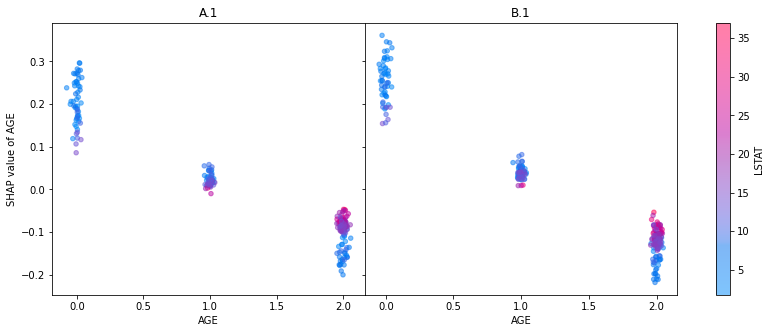

In [27]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'B.1'], 'AGE')
node.plot_feature_dependence('AGE', classes=['A.1', 'B.1'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

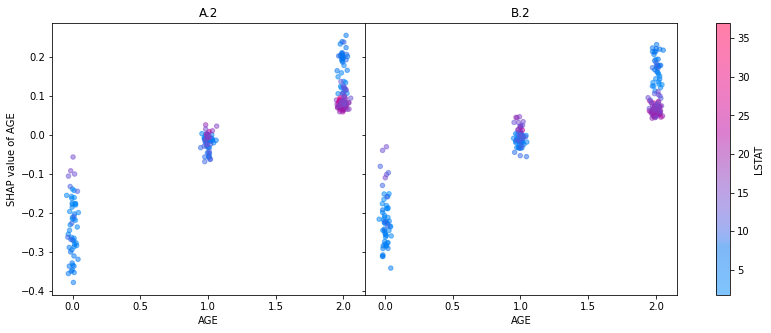

In [28]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'B.2'], 'AGE')
node.plot_feature_dependence('AGE', classes=['A.2', 'B.2'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

# Difference Classifier SHAP Explanations

In [15]:
with open('diffclf.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

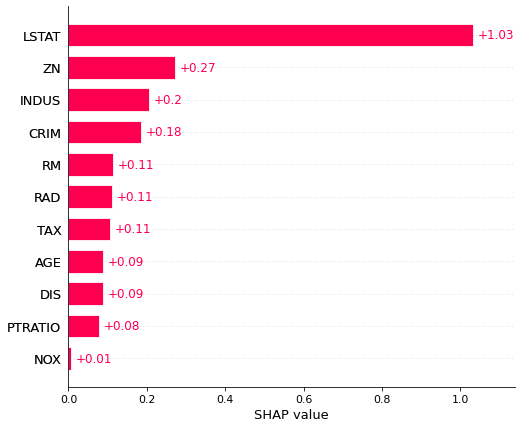

In [16]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

In [17]:
feature_order = feature_order[:-1]

The equality classes (0,0) and (2,2) have the highest mean absolute SHAP value, which means that the influences to and from these classes are highest. 

(0,2) and (2,0) have the least importances.

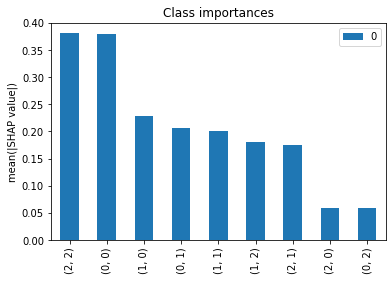

In [18]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

In [19]:
class_order = np.sort(class_order[:-2])

In [20]:
def plot(feature):
    node.describe_feature_differences(feature)
    pprint(node.counterfactuals[feature])
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

In [21]:
def plot_2d(node, x, y):
    comparer.plot_decision_boundaries(node.root.data, x=x, y=y, alpha=0.5, show=False)
    for cf in node.counterfactuals[x]:
        plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
    for cf in node.counterfactuals[y]:
        plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

## Clustering of Class $(0,1)$ SHAP Values

In [11]:
focus_class = '(0, 1)'

In [12]:
%%time
node = make_clustering(comparer, diffclf_shap_values,
                       focus_class, ['(0, 0)', '(0, 1)', '(1, 1)'],
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions)
with open(f'clustering.{focus_class}.pickle', 'wb') as f:
    pickle.dump(node, f)
node.class_counts, node.distance

CPU times: user 6.18 s, sys: 85.4 ms, total: 6.26 s
Wall time: 6.98 s


((2, 2)    96
 (0, 0)    86
 (1, 1)    52
 (1, 2)     5
 (0, 1)     3
 (2, 1)     2
 (1, 0)     2
 dtype: int64,
 57.64514718994521)

In [13]:
with open(f'clustering.{focus_class}.pickle', 'rb') as f:
    node = pickle.load(f)
with open(f'ground_truth.{node.diff_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

### Main Node (LLR)

In [13]:
node = node.root.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LLR,
 (1, 1)    16
 (0, 0)     8
 (0, 1)     3
 (1, 0)     2
 dtype: int64,
 7.750876998979743)

In [15]:
feature_it = iter(node.features_with_counterfactuals)

The differences are in a certain range, where the dependence curve of the difference class has a global high.

11.1 <= LSTAT <= 14.19
[Lower CF: LSTAT == 10.48 --> {'(1, 1)': 3},
 Upper CF: LSTAT == 14.9 --> {'(0, 0)': 3}]


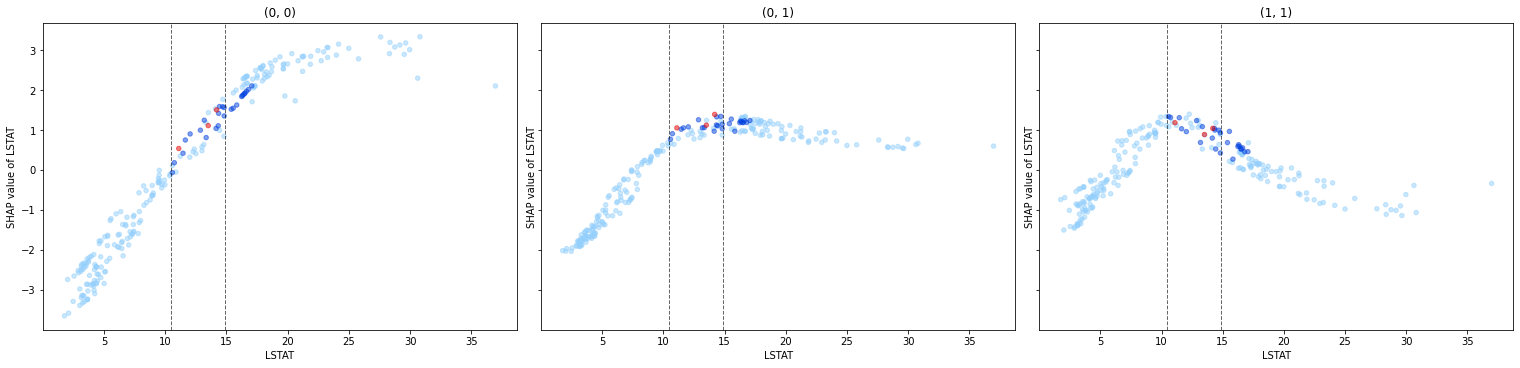

In [16]:
feature = next(feature_it)
plot(feature)

In [32]:
part = node.root.filter((10.48 < node.root.data['LSTAT']) & (node.root.data['LSTAT'] <= 14.89))

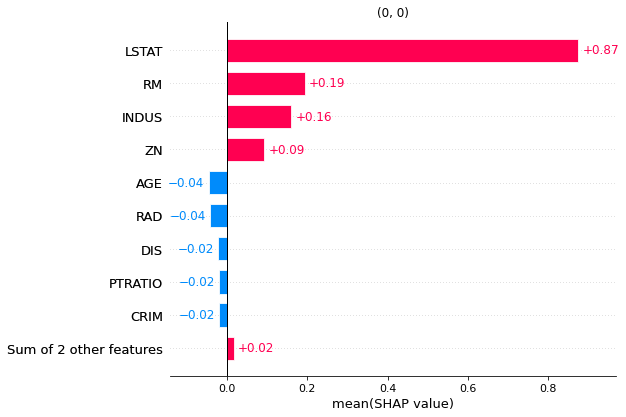

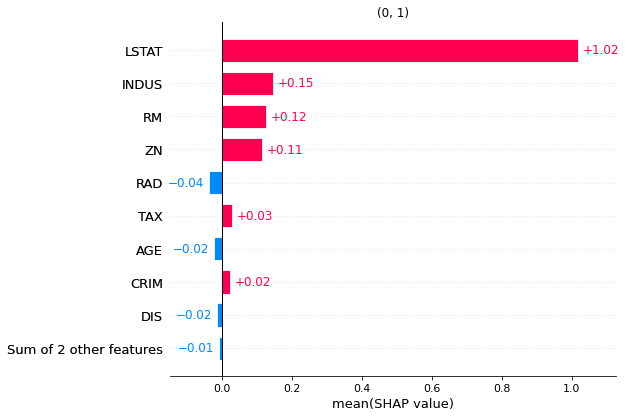

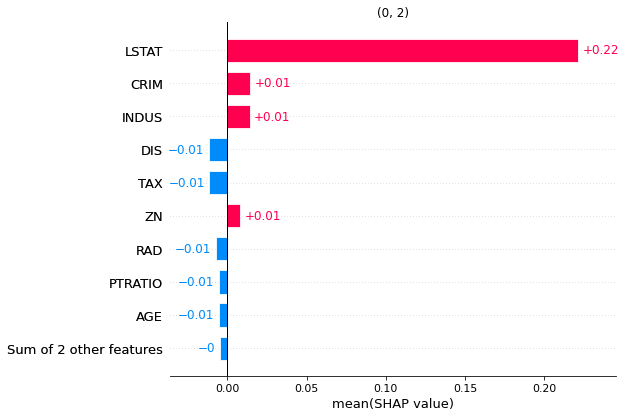

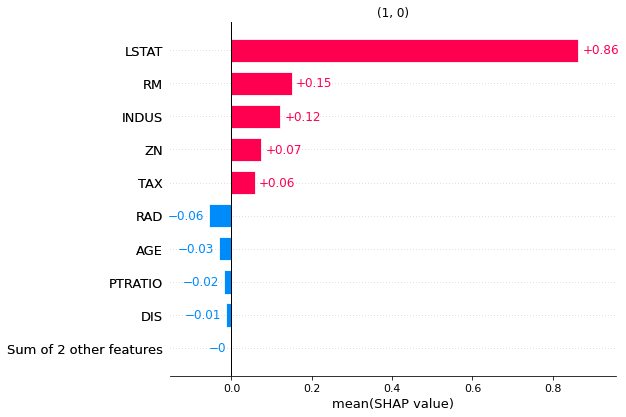

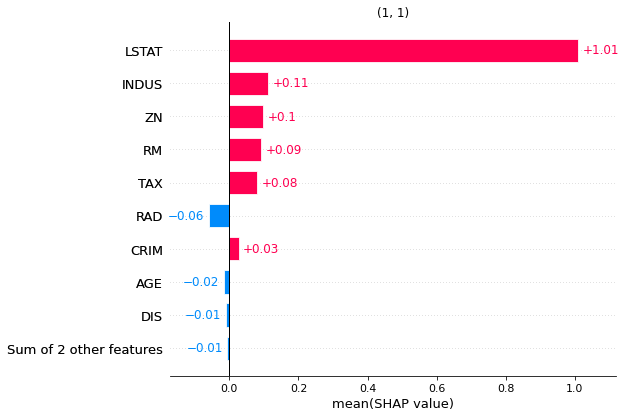

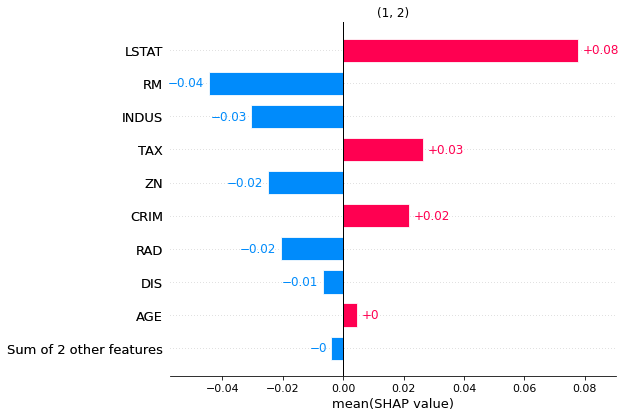

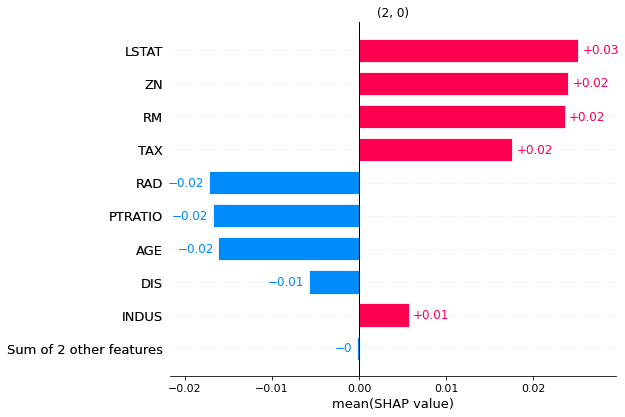

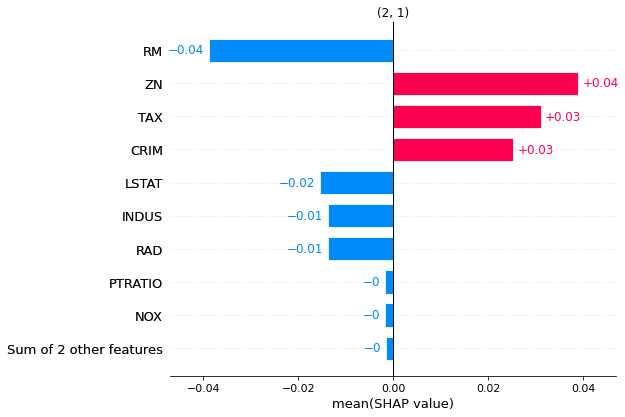

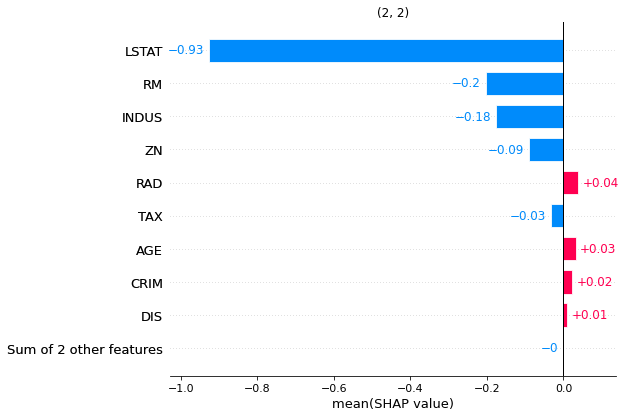

In [17]:
for class_name in comparer.class_names:
    bar(part.shap_values[:, :, class_name].mean(0), show=False)
    plt.title(class_name)
    plt.show()

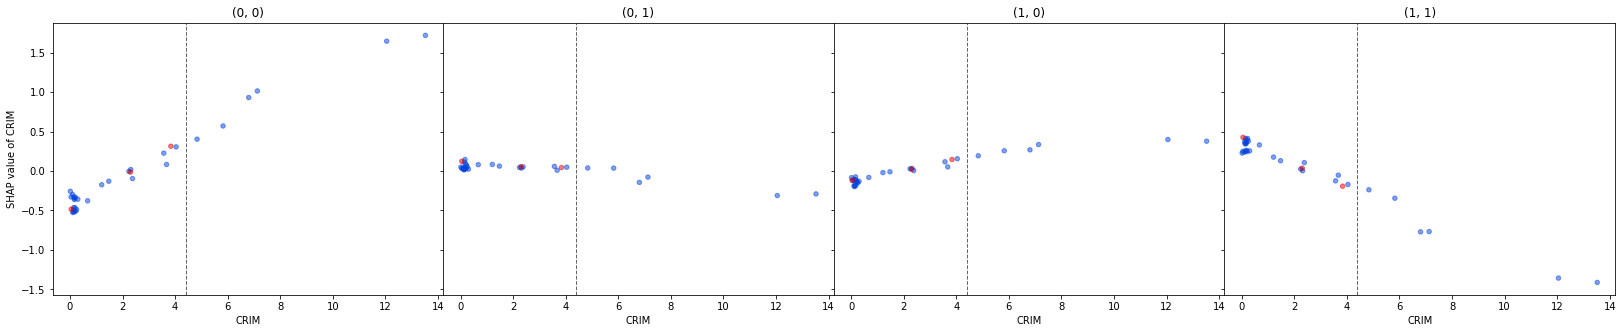

In [36]:
part.plot_feature_dependence('CRIM', alpha=0.5, classes=['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)'])

In [37]:
part.counterfactuals['CRIM']

[Upper CF: CRIM == 4.4 --> {'(0, 0)': 3}]

In [38]:
part = part.filter(part.data['CRIM'] < 4.4)

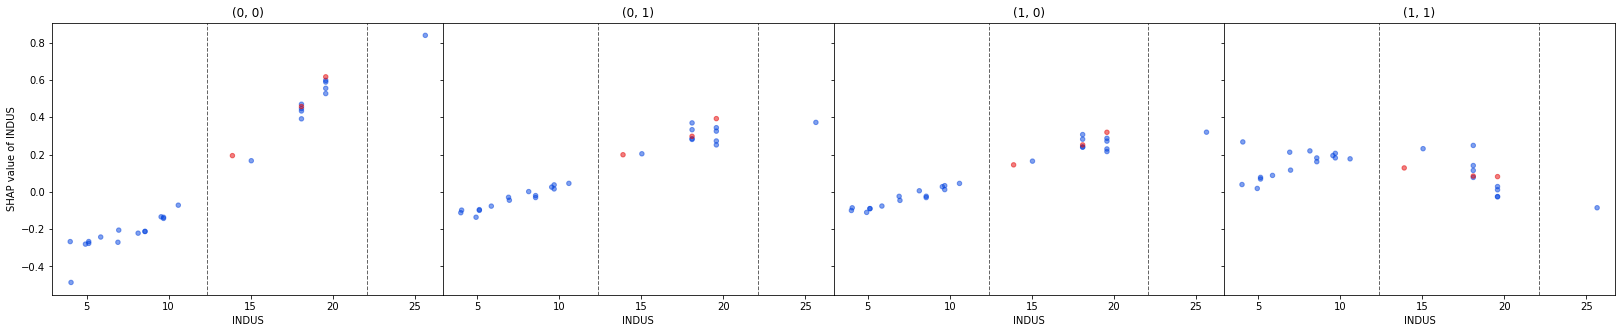

In [40]:
part.plot_feature_dependence('INDUS', alpha=0.5, classes=['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)'])

In [41]:
part.counterfactuals['INDUS']

[Lower CF: INDUS == 12.37 --> {'(1, 1)': 3},
 Upper CF: INDUS == 22.11 --> {'(0, 0)': 3}]

In [42]:
part = part.filter((12.37 < part.data['INDUS']) & (part.data['INDUS'] <= 22.10))

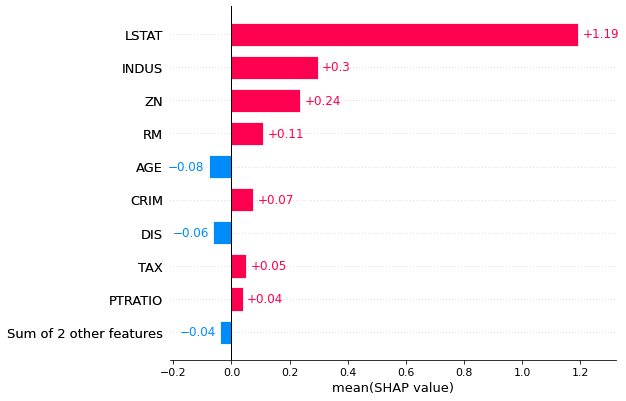

In [45]:
bar(part.shap_values[part.highlight, :, '(0, 1)'].mean(0))

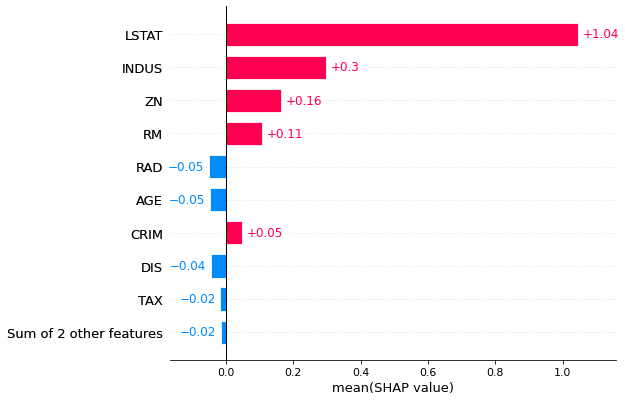

In [46]:
bar(part.shap_values[~part.highlight, :, '(0, 1)'].mean(0))

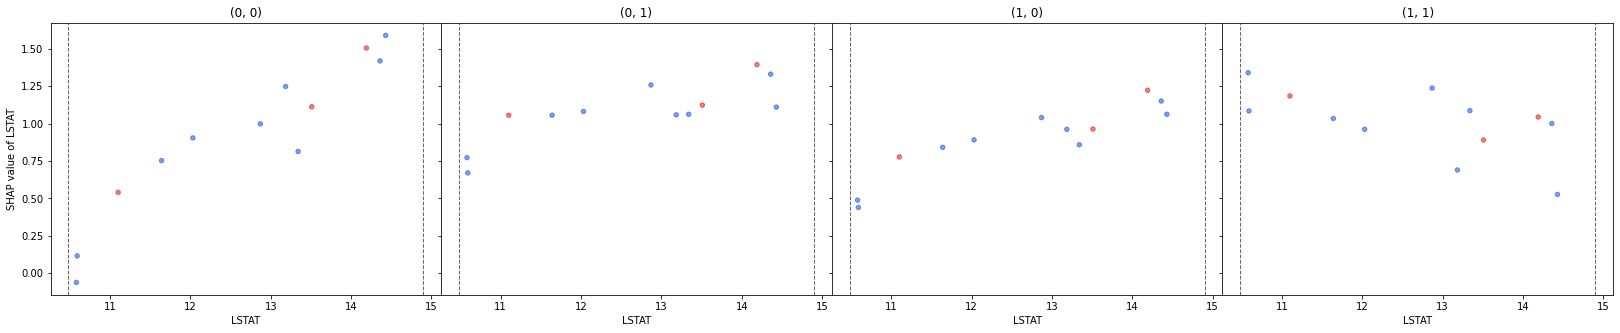

In [47]:
part.plot_feature_dependence('LSTAT', alpha=0.5, classes=['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)'])

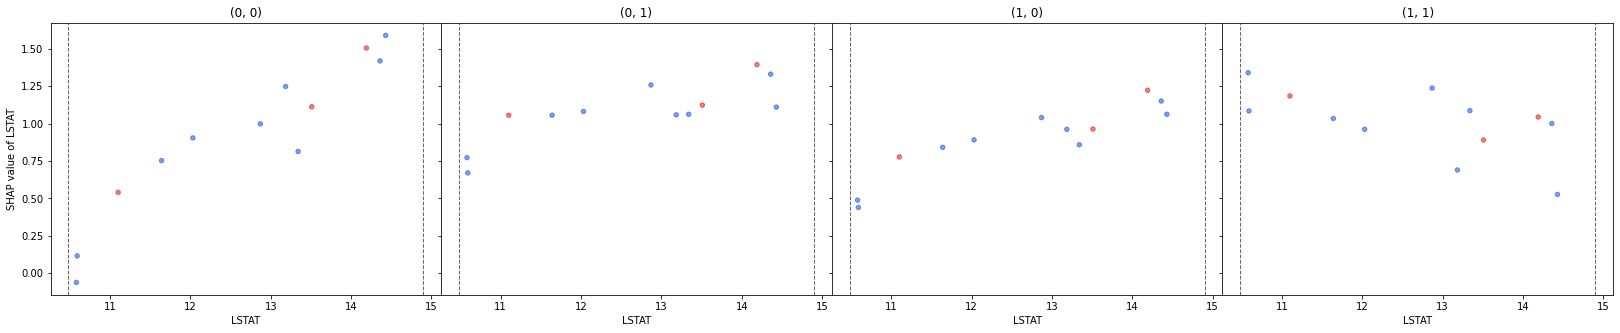

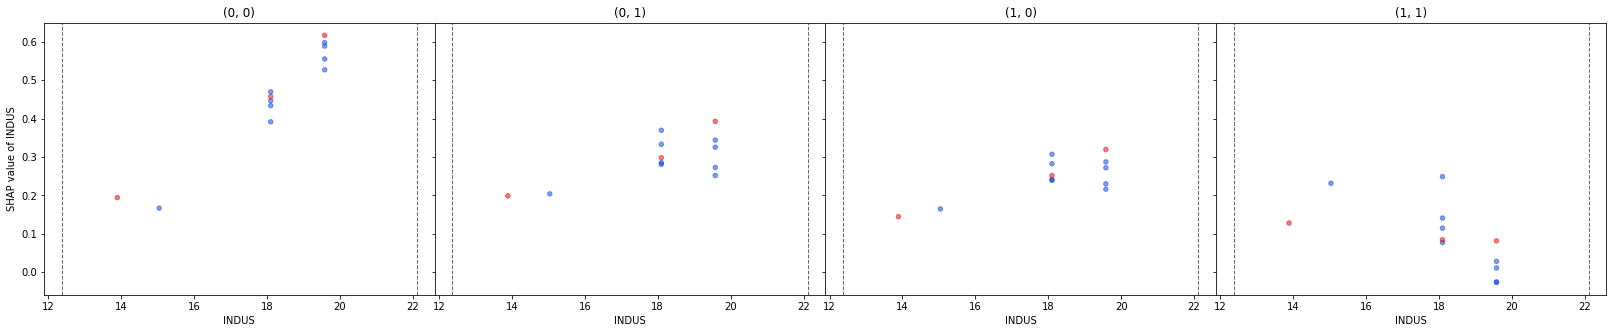

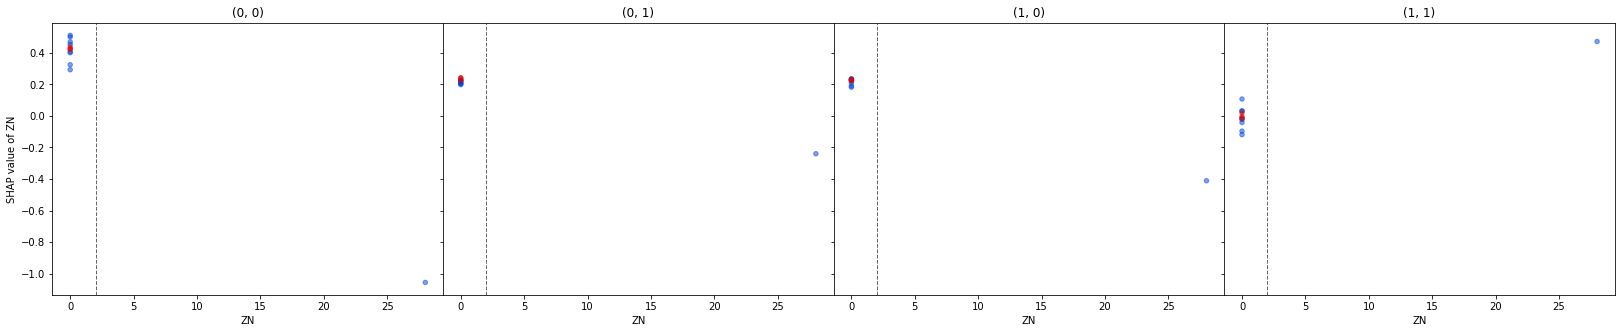

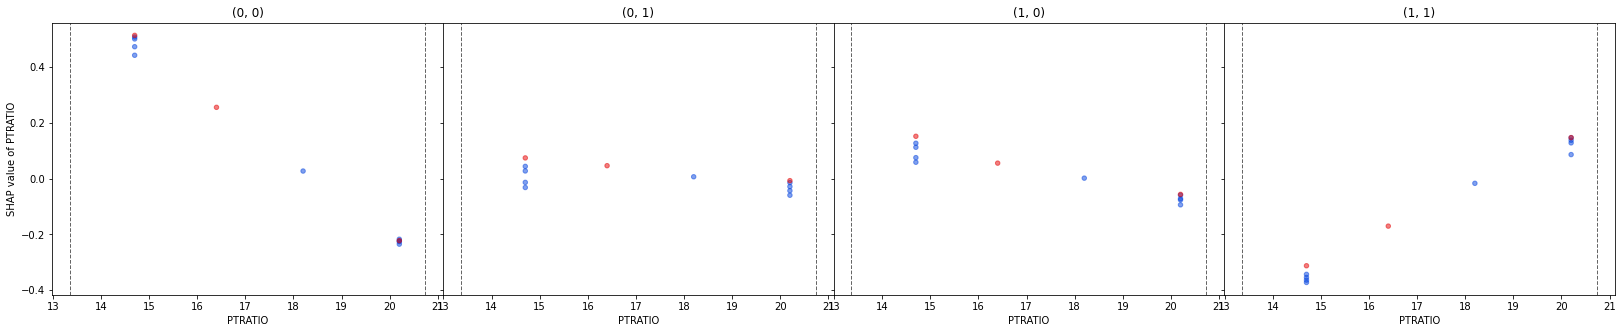

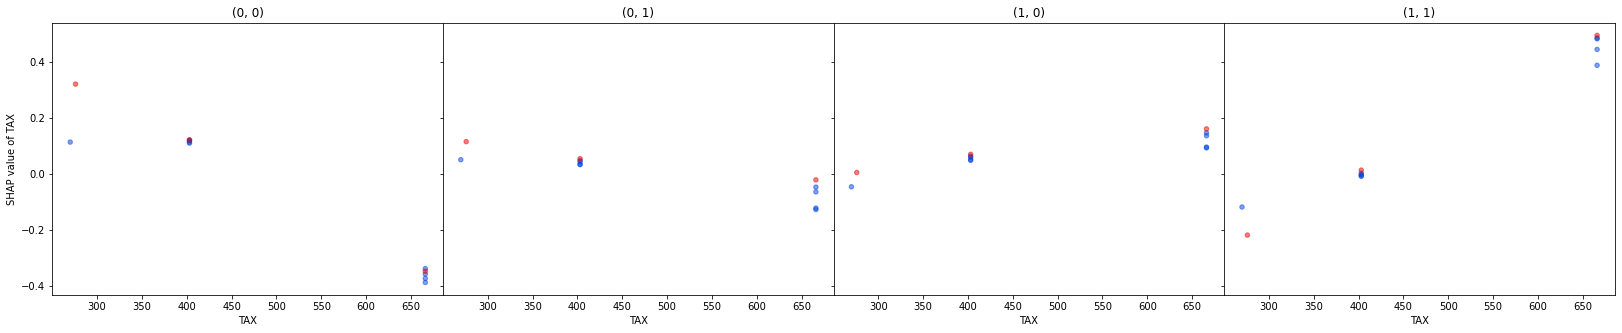

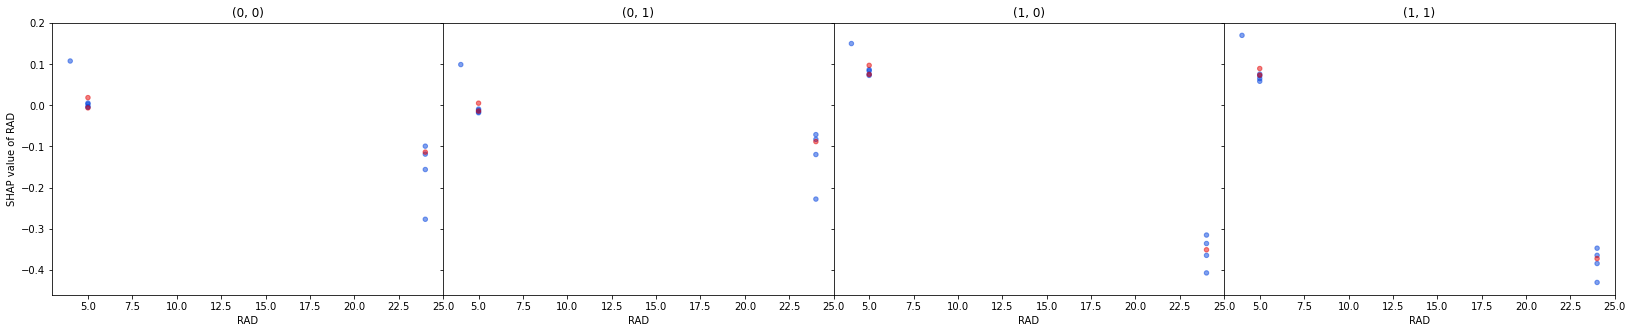

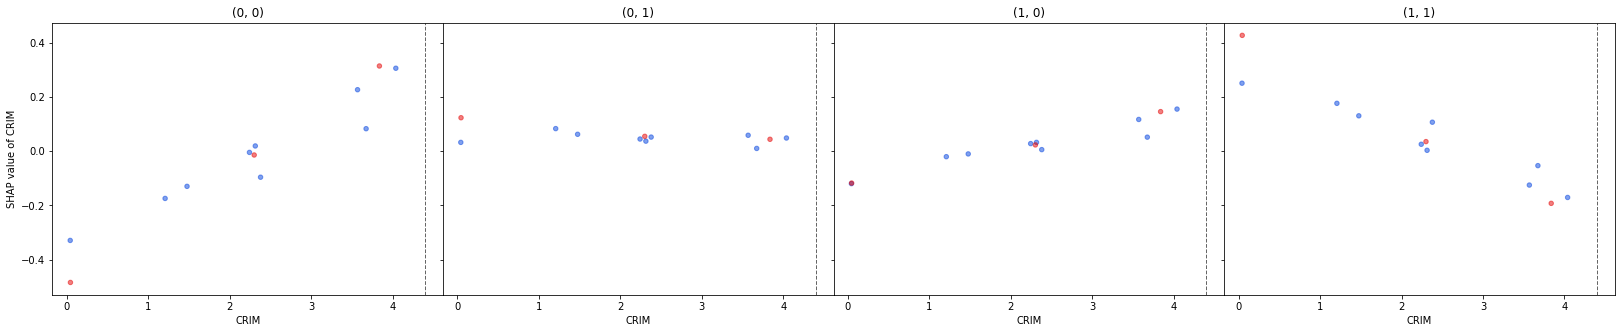

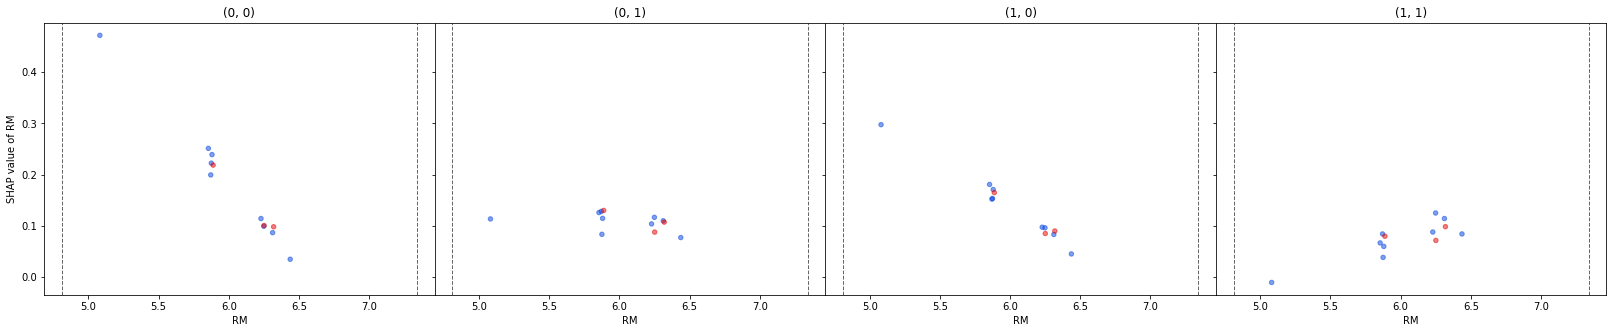

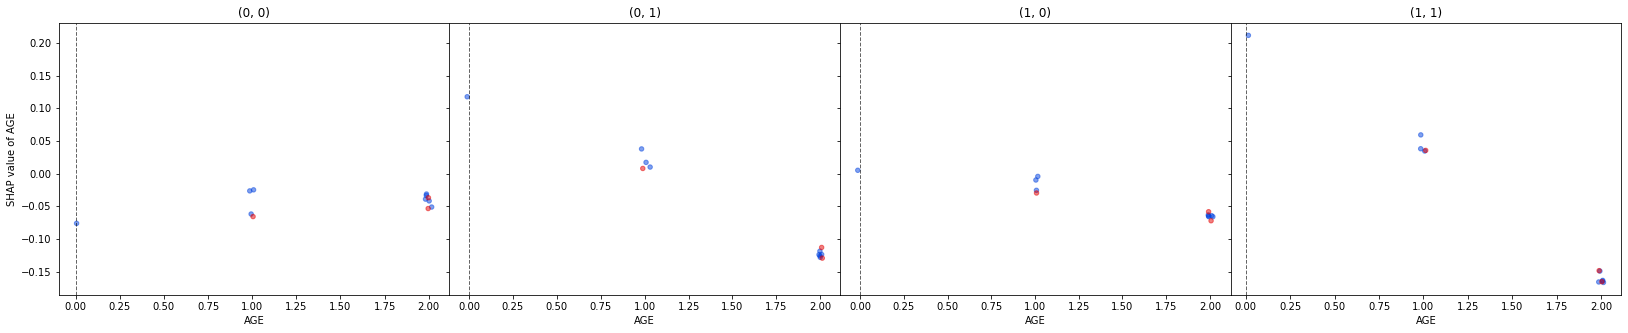

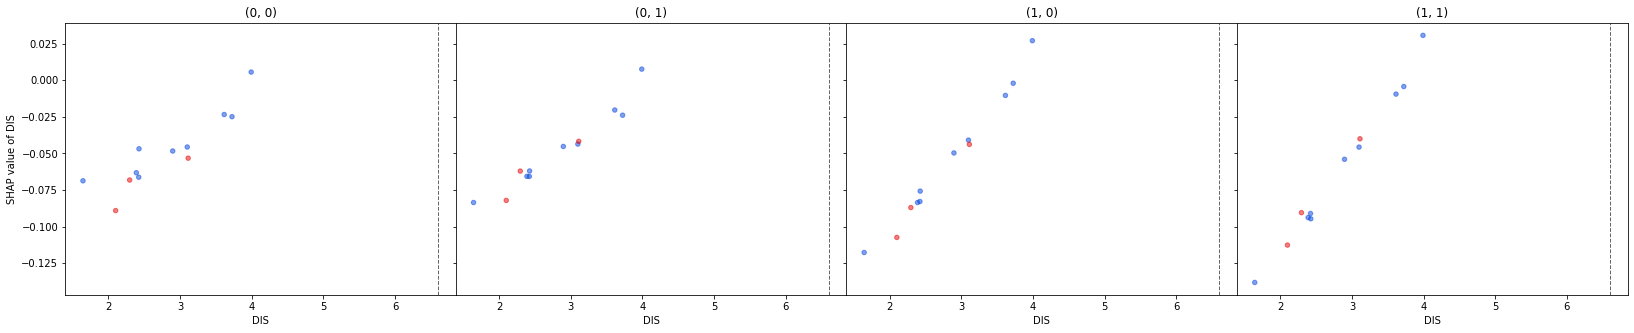

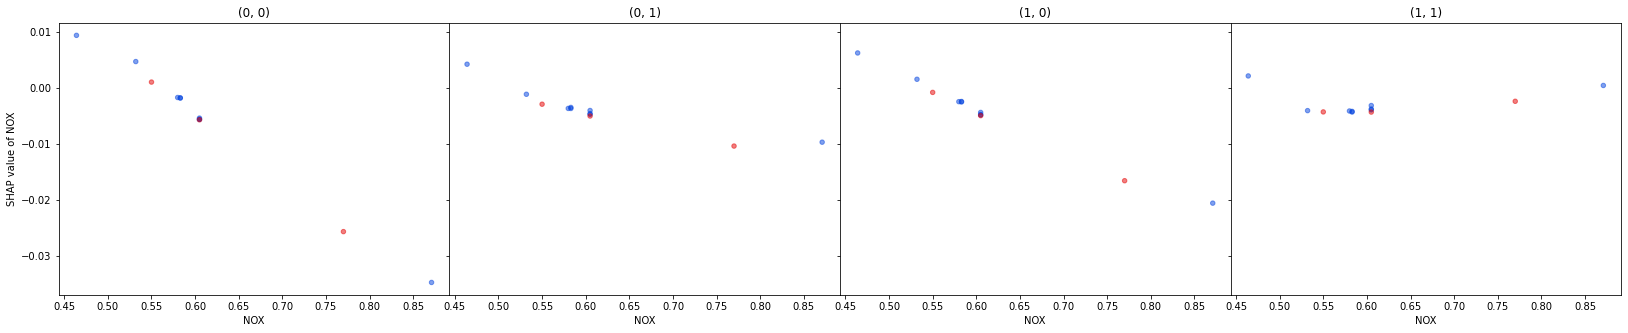

In [43]:
for feature in part.features_ordered:
    part.plot_feature_dependence(feature, alpha=0.5, classes=['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)'])
    plt.show()

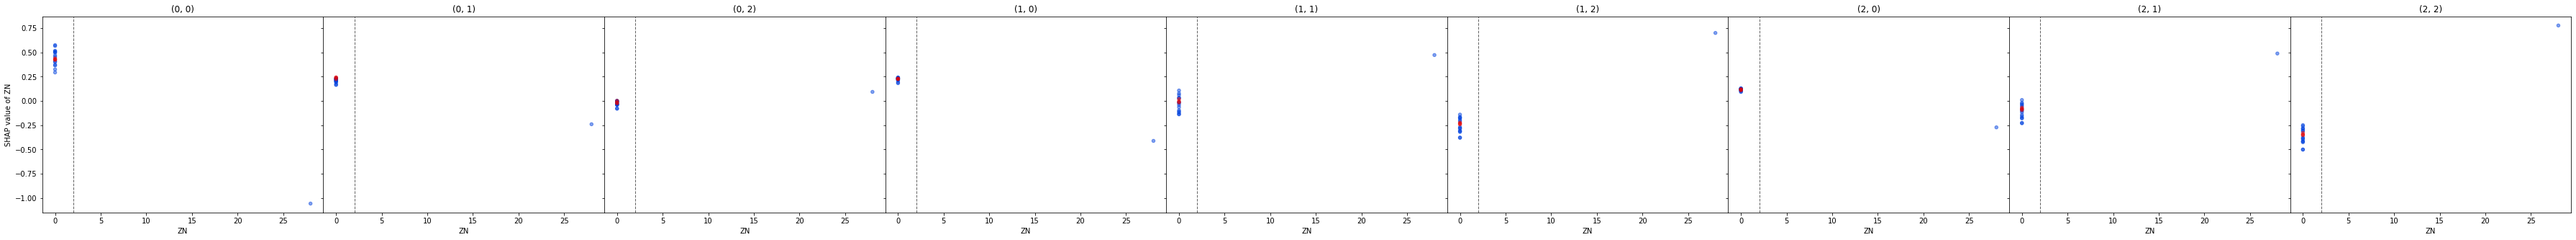

In [31]:
part.plot_feature_dependence('ZN', alpha=0.5, classes=comparer.class_names)

13.89 <= INDUS <= 19.58
[Lower CF: INDUS == 12.37 --> {'(1, 1)': 3},
 Upper CF: INDUS == 22.11 --> {'(0, 0)': 3}]


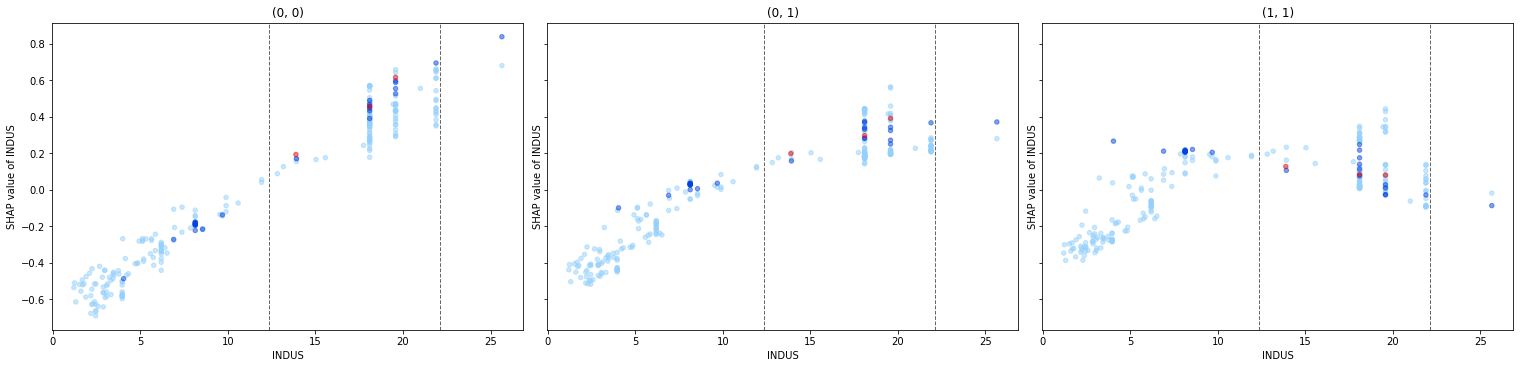

In [17]:
feature = next(feature_it)
plot(feature)

ZN is zero for all instances classified differently, and at 2, all instances flip to $(1,1)$, which has highest outcome increase there.

ZN == 0.0
[Upper CF: ZN == 2.0 --> {'(1, 1)': 3}]


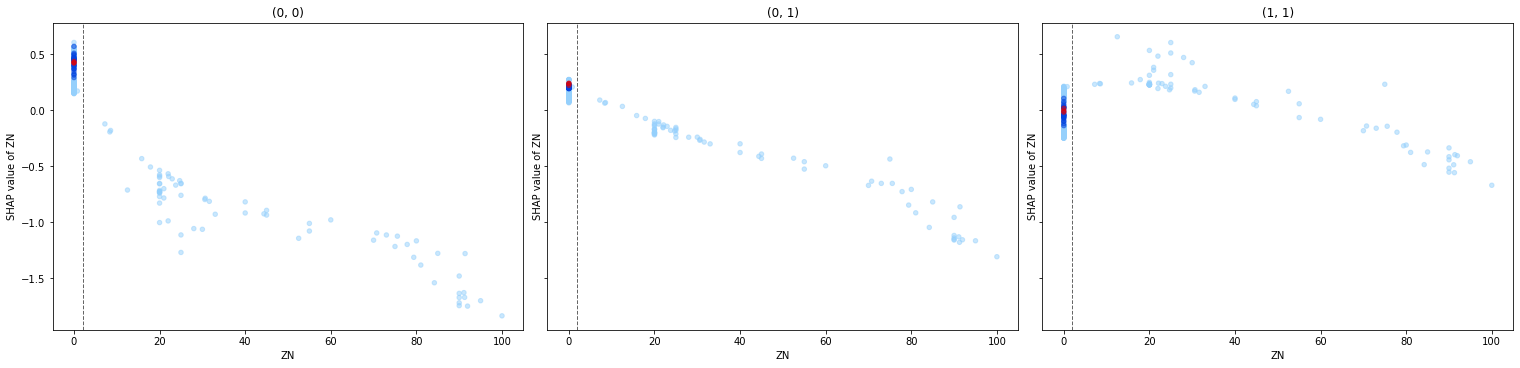

In [18]:
feature = next(feature_it)
plot(feature)

The $(0,0)$ outcomes of CRIM increase linearly for increasing values, at 5 all instances classified differently flip to this class.

0.0456 <= CRIM <= 3.83684
[Upper CF: CRIM == 5.0 --> {'(0, 0)': 3}]


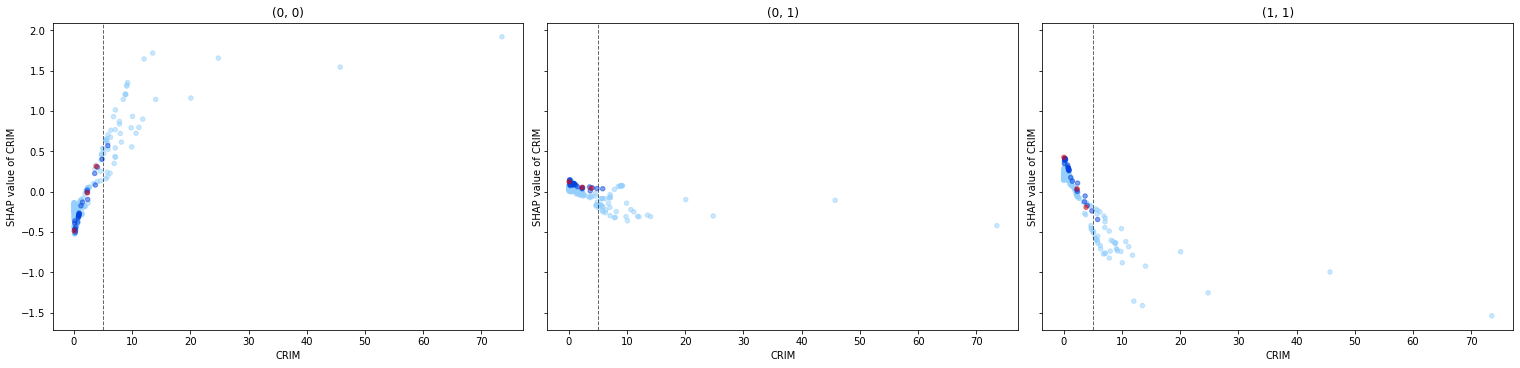

In [19]:
feature = next(feature_it)
plot(feature)

CFs are on the far edges outside the main feature value distribution, skipping it.

14.7 <= PTRATIO <= 20.2
[Lower CF: PTRATIO == 13.36 --> {'(0, 0)': 3},
 Upper CF: PTRATIO == 20.74 --> {'(1, 1)': 3}]


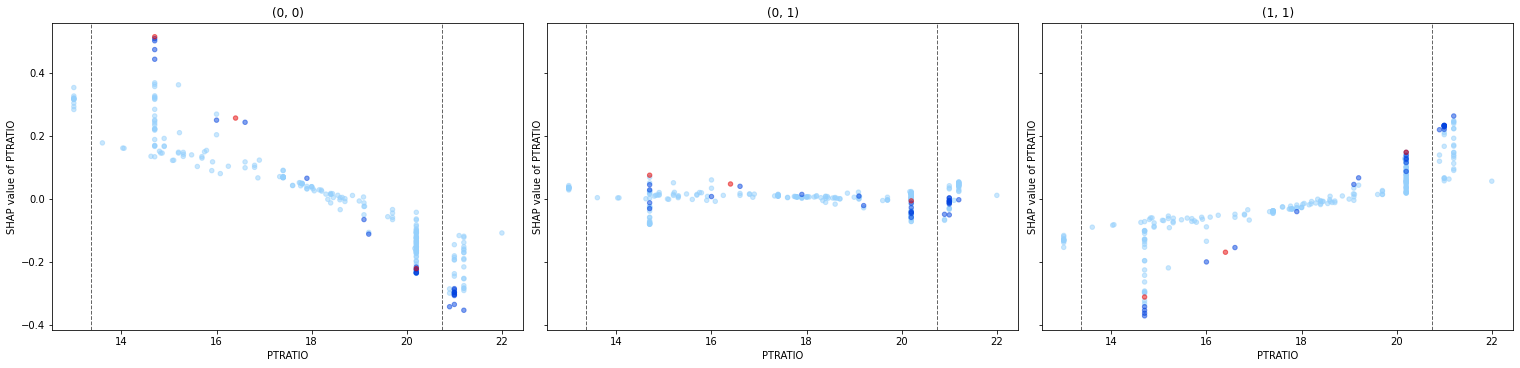

In [20]:
feature = next(feature_it)
plot(feature)

similar here.

5.888 <= RM <= 6.319
[Lower CF: RM == 4.81 --> {'(0, 0)': 3}, Upper CF: RM == 7.34 --> {'(1, 1)': 3}]


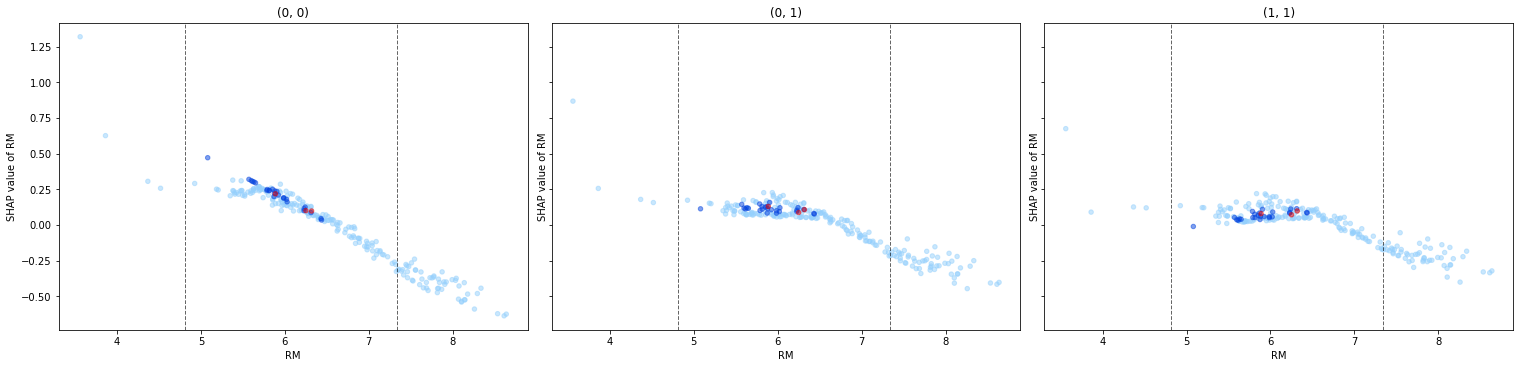

In [21]:
feature = next(feature_it)
plot(feature)

For AGE, I see a linear trend for the current cluster for all classes. Locally, higher values tend to increase the outcome of $(1,1)$, and to a lesser extent that of the difference class.

1.0 <= AGE
[Lower CF: AGE == 0.0 --> {'(1, 1)': 3}]


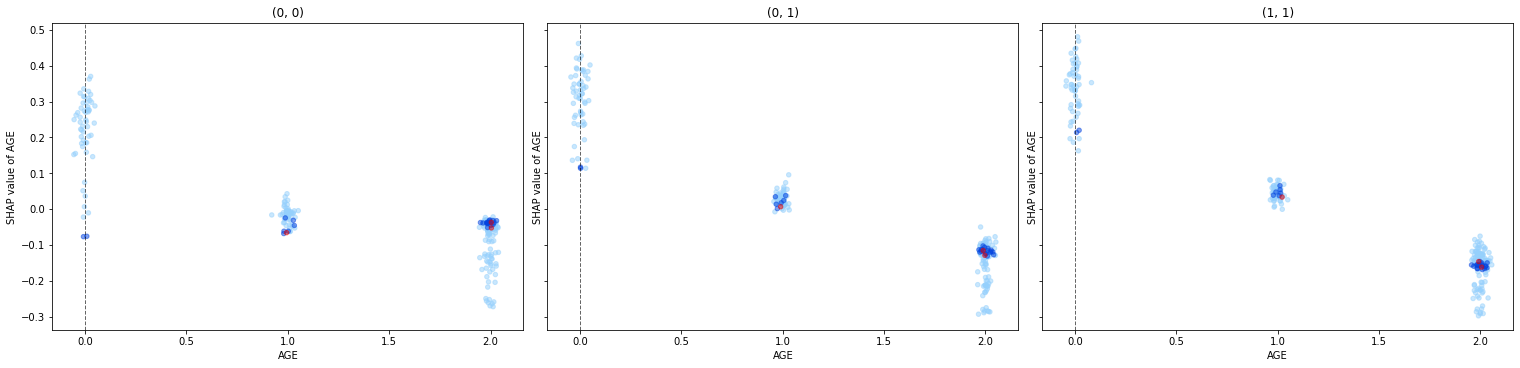

In [22]:
feature = next(feature_it)
plot(feature)

In [23]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'INDUS', 'ZN', 'CRIM', 'AGE')
print(rule)
node.evaluate_rules(rule)

10.48 < LSTAT <= 14.89 and 12.37 < INDUS <= 22.1 and ZN <= 1.0 and CRIM <= 4.0 and AGE > 0.0
              precision    recall  f1-score   support

       False       1.00      0.77      0.87        26
        True       0.33      1.00      0.50         3

    accuracy                           0.79        29
   macro avg       0.67      0.88      0.68        29
weighted avg       0.93      0.79      0.83        29



In [24]:
explanations_global = [(rule, constraint, instance_indices)]

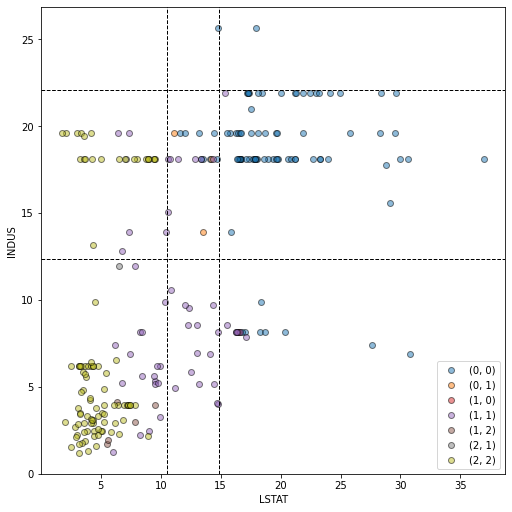

In [25]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Evaluation

In [26]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

#### Global Fidelity

In [27]:
print_rules(rules)
node.root.evaluate_rules(*rules)

1. 10.48 < LSTAT <= 14.89 and 12.37 < INDUS <= 22.1 and ZN <= 1.0 and CRIM <= 4.0 and AGE > 0.0
              precision    recall  f1-score   support

       False       1.00      0.98      0.99       243
        True       0.33      1.00      0.50         3

    accuracy                           0.98       246
   macro avg       0.67      0.99      0.74       246
weighted avg       0.99      0.98      0.98       246



#### Counterfactual Fidelity Error

In [28]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [29]:
rmse

CRIM       2.081666
ZN         0.816497
INDUS      2.744768
NOX             NaN
RM              NaN
AGE        0.577350
DIS             NaN
RAD             NaN
TAX             NaN
PTRATIO         NaN
LSTAT      2.301308
dtype: float64

In [30]:
boundary_miss_rate

CRIM       0.4
ZN         0.0
INDUS      0.0
NOX        NaN
RM         1.0
AGE        0.0
DIS        1.0
RAD        1.0
TAX        1.0
PTRATIO    1.0
LSTAT      0.0
dtype: float64

In [31]:
boundary_add_rate

CRIM       0.0
ZN         0.0
INDUS      0.0
NOX        NaN
RM         NaN
AGE        0.0
DIS        NaN
RAD        NaN
TAX        NaN
PTRATIO    NaN
LSTAT      0.0
dtype: float64

#### Complexity

In [32]:
get_complexity(constraints)

Number of rules: 1
Number of constraints: 7 (7.0 per rule)


## Clustering of Class $(1,0)$ SHAP Values

In [12]:
focus_class = '(1, 0)'

In [13]:
%%time
node = make_clustering(comparer, diffclf_shap_values,
                       focus_class, ['(0, 0)', '(1, 0)', '(1, 1)'],
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions)
with open(f'clustering.{focus_class}.pickle', 'wb') as f:
    pickle.dump(node, f)
node.class_counts, node.distance

CPU times: user 3.25 s, sys: 58.1 ms, total: 3.31 s
Wall time: 3.97 s


((2, 2)    96
 (0, 0)    86
 (1, 1)    52
 (1, 2)     5
 (0, 1)     3
 (1, 0)     2
 (2, 1)     2
 dtype: int64,
 61.84152968618271)

In [34]:
with open(f'clustering.{focus_class}.pickle', 'rb') as f:
    node = pickle.load(f)
with open(f'ground_truth.{node.diff_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

### Main Node (LLRRRLRLR)

In [36]:
node = node.root.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LLRRRLRLR,
 (1, 0)    2
 dtype: int64,
 0.0008613046886894104)

Compared to the $(0,1)$ differences, these are much closer to the outcomes of both $(0,0)$ and $(1,1)$.

In [38]:
feature_it = iter(node.features_with_counterfactuals)

The differences are very specific to a local LSTAT range, with close CFs

16.476581495471024 <= LSTAT <= 16.51
[Lower CF: LSTAT == 16.33 --> {'(1, 1)': 2},
 Upper CF: LSTAT == 16.72 --> {'(0, 0)': 2}]


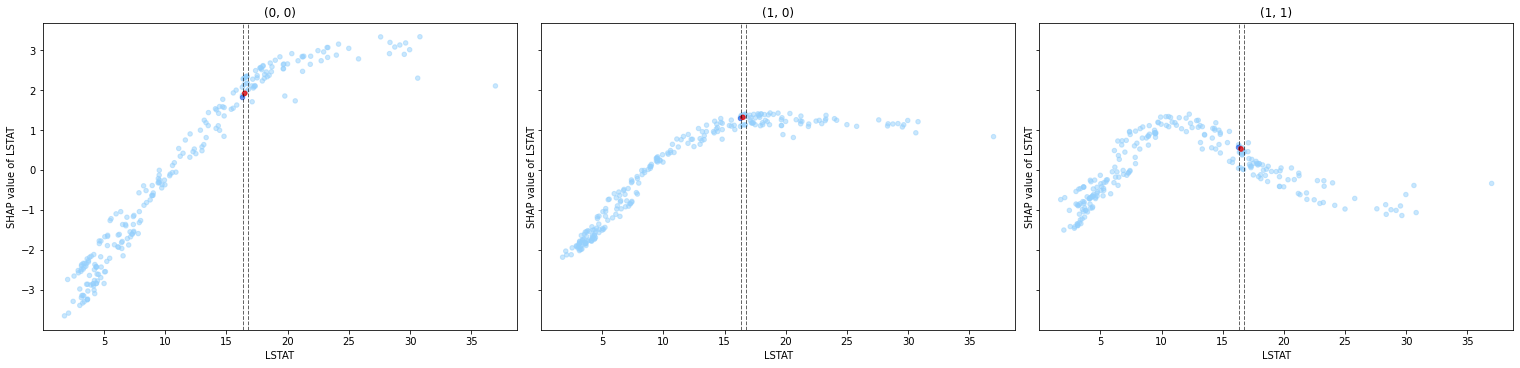

In [39]:
feature = next(feature_it)
plot(feature)

ZN is zero, with very close CF

ZN == 0.0
[Upper CF: ZN == 1.0 --> {'(1, 1)': 2}]


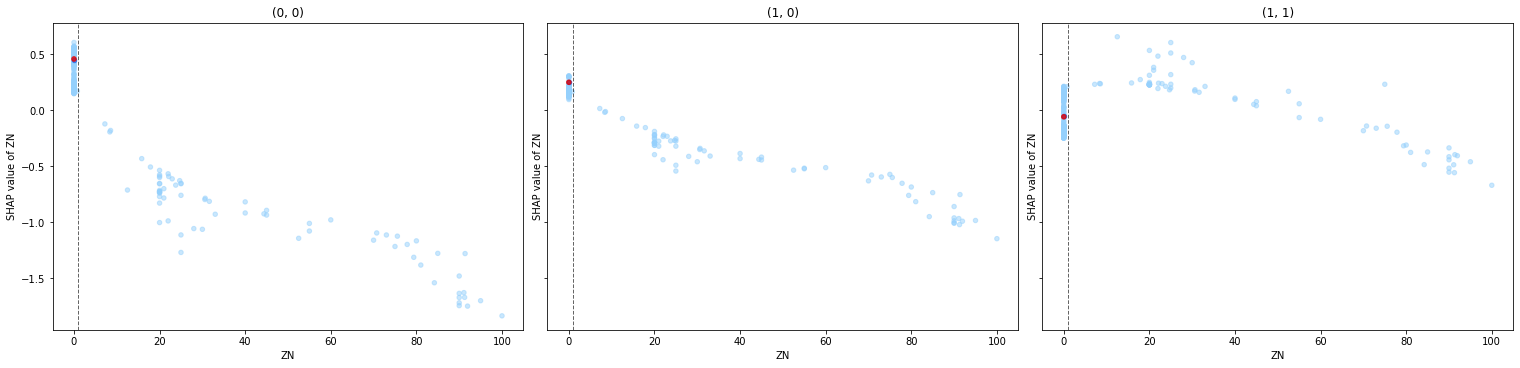

In [40]:
feature = next(feature_it)
plot(feature)

0.8261732257672565 <= CRIM <= 0.84054
[Lower CF: CRIM == 0.0 --> {'(1, 1)': 2},
 Upper CF: CRIM == 2.0 --> {'(0, 0)': 2}]


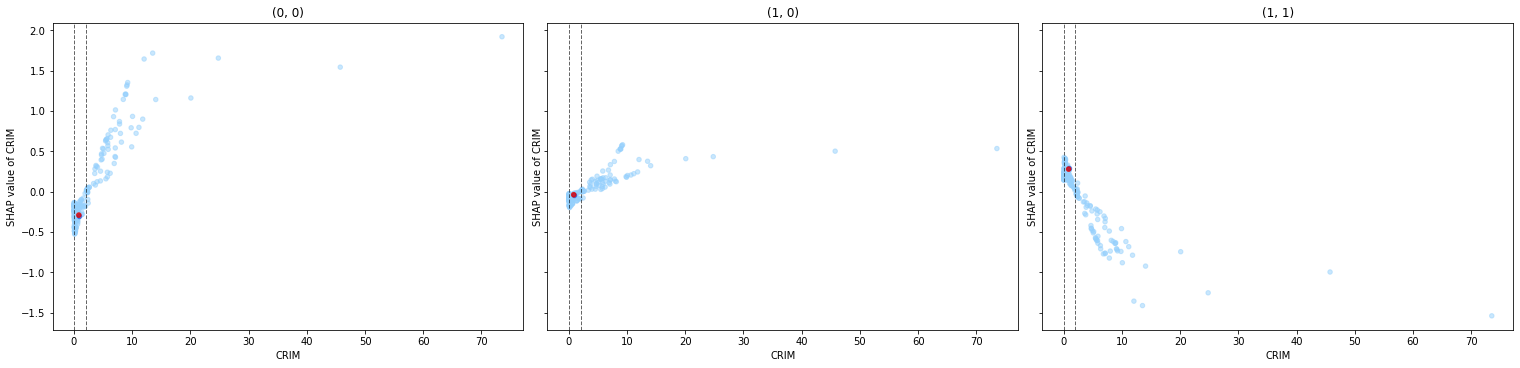

In [41]:
feature = next(feature_it)
plot(feature)

PTRATIO == 21.0
[Lower CF: PTRATIO == 20.58 --> {'(0, 0)': 2},
 Upper CF: PTRATIO == 21.39 --> {'(1, 1)': 2}]


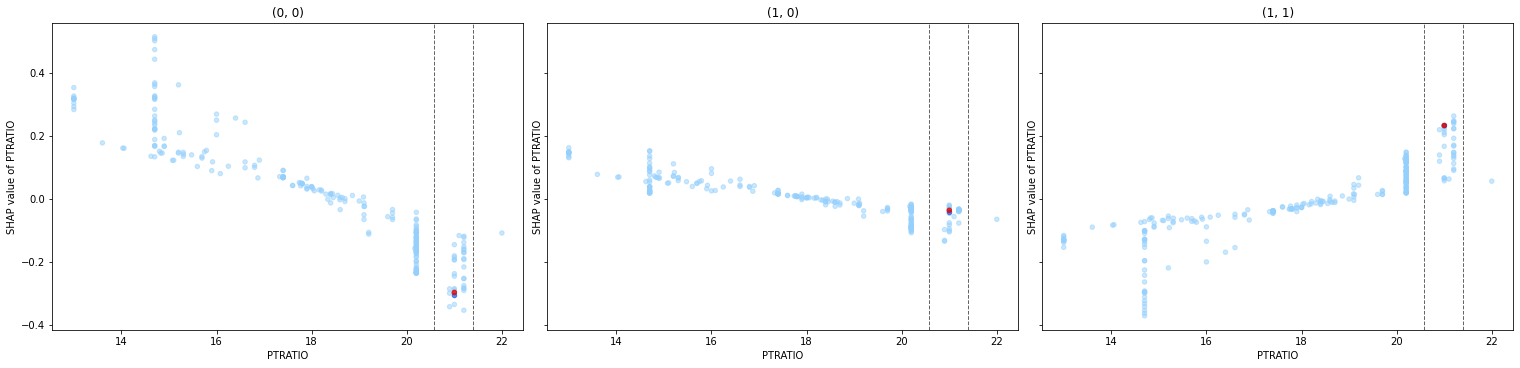

In [42]:
feature = next(feature_it)
plot(feature)

INDUS == 8.14
[Lower CF: INDUS == 7.13 --> {'(1, 1)': 2},
 Upper CF: INDUS == 9.15 --> {'(0, 0)': 2}]


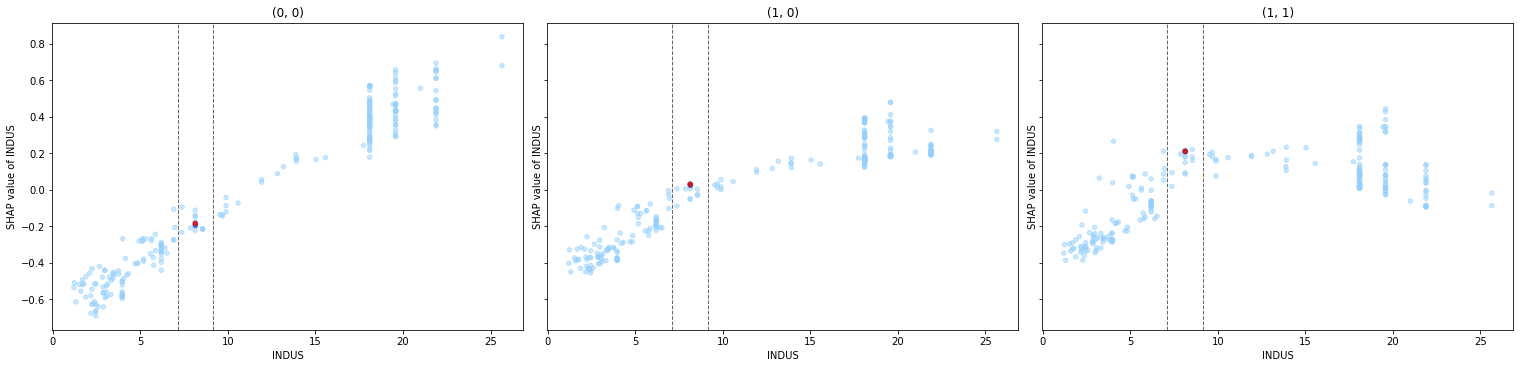

In [43]:
feature = next(feature_it)
plot(feature)

The terms derived so far are enough to classify the instances correctly.

In [44]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'ZN', 'CRIM', 'PTRATIO', 'RM')
print(rule)
node.evaluate_rules(rule)

16.33 < LSTAT <= 16.71 and ZN <= 0.0 and 0.0 < CRIM <= 1.0 and 20.58 < PTRATIO <= 21.38 and 5.22 < RM <= 5.75
              precision    recall  f1-score   support

       False       1.00      1.00      1.00         1
        True       1.00      1.00      1.00         2

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



In [45]:
explanations_global = [(rule, constraint, instance_indices)]

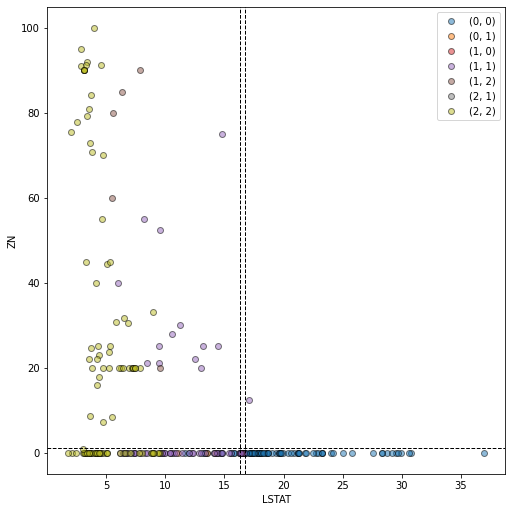

In [46]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Evaluation

In [47]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

#### Global Fidelity

In [48]:
print_rules(rules)
node.root.evaluate_rules(*rules)

1. 16.33 < LSTAT <= 16.71 and ZN <= 0.0 and 0.0 < CRIM <= 1.0 and 20.58 < PTRATIO <= 21.38 and 5.22 < RM <= 5.75
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       244
        True       1.00      1.00      1.00         2

    accuracy                           1.00       246
   macro avg       1.00      1.00      1.00       246
weighted avg       1.00      1.00      1.00       246



#### Counterfactual Fidelity Error

In [49]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

invalid value encountered in true_divide


In [50]:
rmse

CRIM       0.000000
ZN         0.000000
INDUS           NaN
NOX             NaN
RM         0.044721
AGE             NaN
DIS             NaN
RAD             NaN
TAX             NaN
PTRATIO    0.129711
LSTAT      0.040311
dtype: float64

In [51]:
boundary_miss_rate

CRIM       0.0
ZN         0.0
INDUS      1.0
NOX        1.0
RM         0.0
AGE        1.0
DIS        1.0
RAD        1.0
TAX        1.0
PTRATIO    0.0
LSTAT      0.0
dtype: float64

In [52]:
boundary_add_rate

CRIM       0.0
ZN         0.0
INDUS      NaN
NOX        NaN
RM         0.0
AGE        NaN
DIS        NaN
RAD        NaN
TAX        NaN
PTRATIO    0.0
LSTAT      0.0
dtype: float64

#### Complexity

In [53]:
get_complexity(constraints)

Number of rules: 1
Number of constraints: 9 (9.0 per rule)


## Clustering of Class $(1,2)$ SHAP Values

In [10]:
focus_class = '(1, 2)'

In [11]:
%%time
node = make_clustering(comparer, diffclf_shap_values,
                       focus_class, ['(1, 1)', '(1, 2)', '(2, 2)'],
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions)
with open(f'clustering.{focus_class}.pickle', 'wb') as f:
    pickle.dump(node, f)
node.class_counts, node.distance

CPU times: user 17.5 s, sys: 252 ms, total: 17.8 s
Wall time: 20.3 s


((2, 2)    96
 (0, 0)    86
 (1, 1)    52
 (1, 2)     5
 (0, 1)     3
 (2, 1)     2
 (1, 0)     2
 dtype: int64,
 66.9114656985999)

In [12]:
with open(f'clustering.{focus_class}.pickle', 'rb') as f:
    node = pickle.load(f)
with open(f'ground_truth.{node.diff_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

### Main Node (RRL)

The distance of this cluster is much higher than in the final local clusters of the previous classes. Further, the most important local cluster ZN has a quite extreme counterfactual and wide spread of feature values where this difference class is predicted.

In [57]:
node = node.root.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRL,
 (1, 1)    13
 (1, 2)     5
 (2, 2)     1
 dtype: int64,
 13.32955575358383)

In [59]:
feature_it = iter(node.features_with_counterfactuals)

ZN is more important for these instances than LSTAT. Below 16, all instances of the difference class flip to $(1,1)$, because of the increasing effect towards it and the decreasing effect of the difference class.

20.0 <= ZN <= 90.0
[Lower CF: ZN == 16.0 --> {'(1, 1)': 5}]


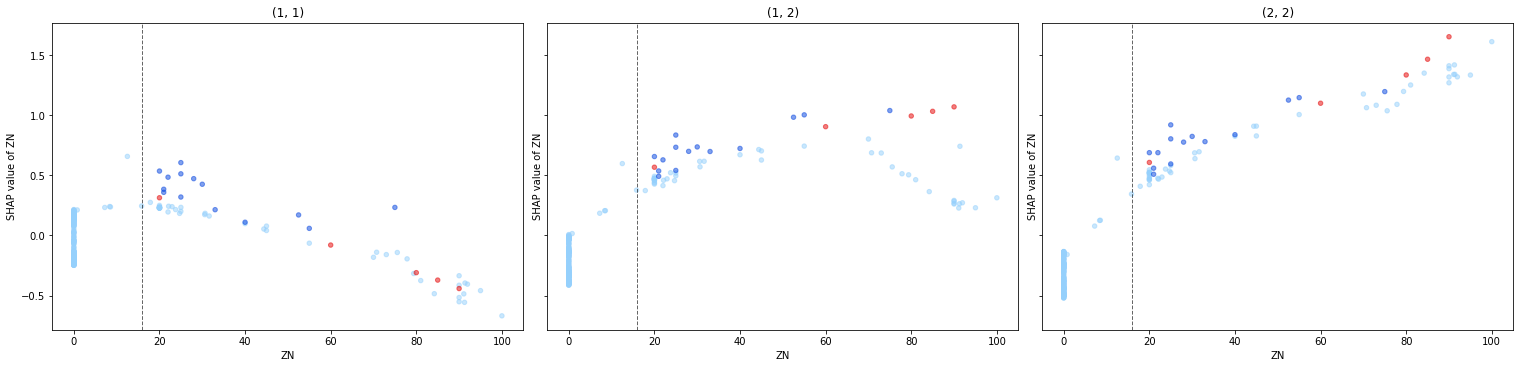

In [60]:
feature = next(feature_it)
plot(feature)

Local high in this range

5.49 <= LSTAT <= 9.522242201272585
[Lower CF: LSTAT == 3.58 --> {'(2, 2)': 5},
 Upper CF: LSTAT == 11.59 --> {'(1, 1)': 5}]


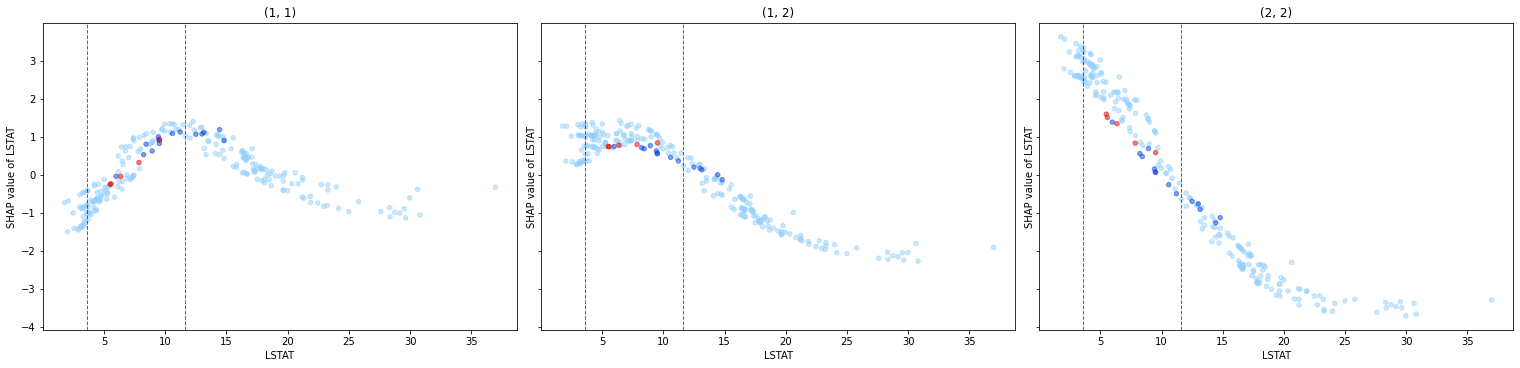

In [61]:
feature = next(feature_it)
plot(feature)

Child nodes may break down these instances, because of the broad range of their SHAP values. Leaving it from the explanation for now.

2.1153479553520422 <= DIS
[Lower CF: DIS == 1.94 --> {'(2, 2)': 5}]


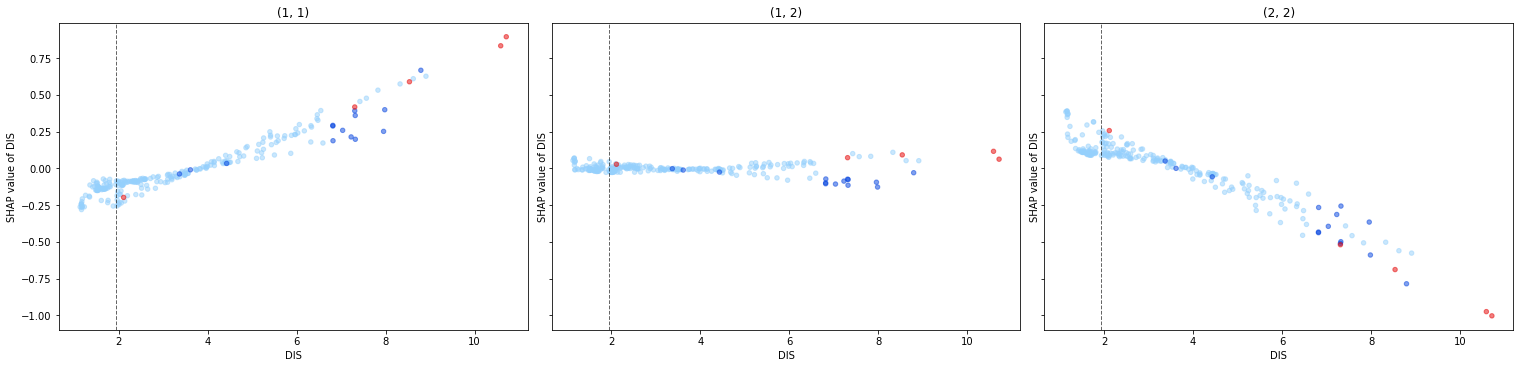

In [62]:
feature = next(feature_it)
plot(feature)

Low values tend towards $(2,2)$ and to a lesser extent towards the difference class.

1.69 <= INDUS <= 4.15
[Upper CF: INDUS == 16.13 --> {'(1, 1)': 5}]


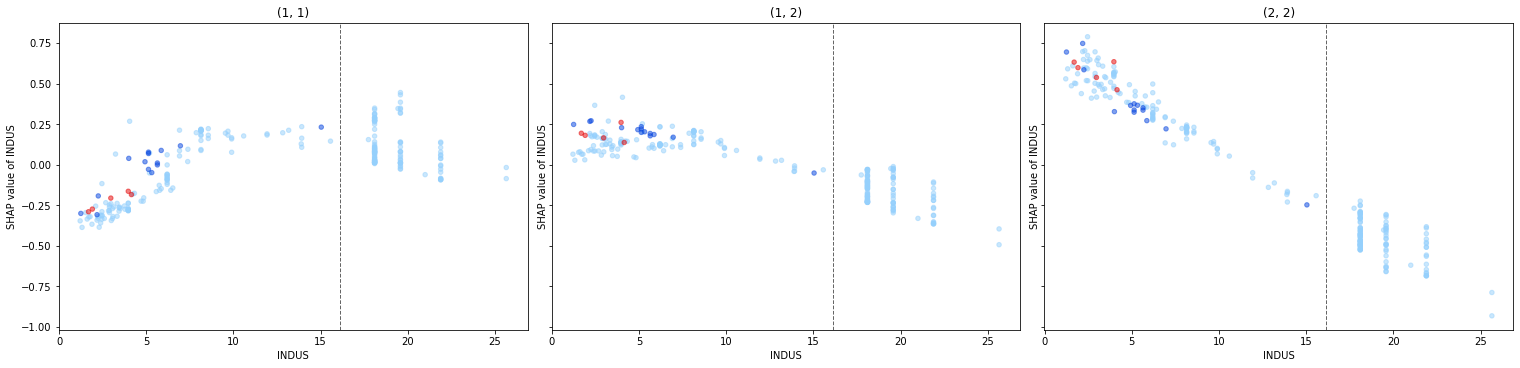

In [63]:
feature = next(feature_it)
plot(feature)

CF very far off of main distribution.

CRIM <= 0.539742303467232
[Upper CF: CRIM == 43.0 --> {'(2, 2)': 3, '(0, 0)': 1, '(1, 0)': 1}]


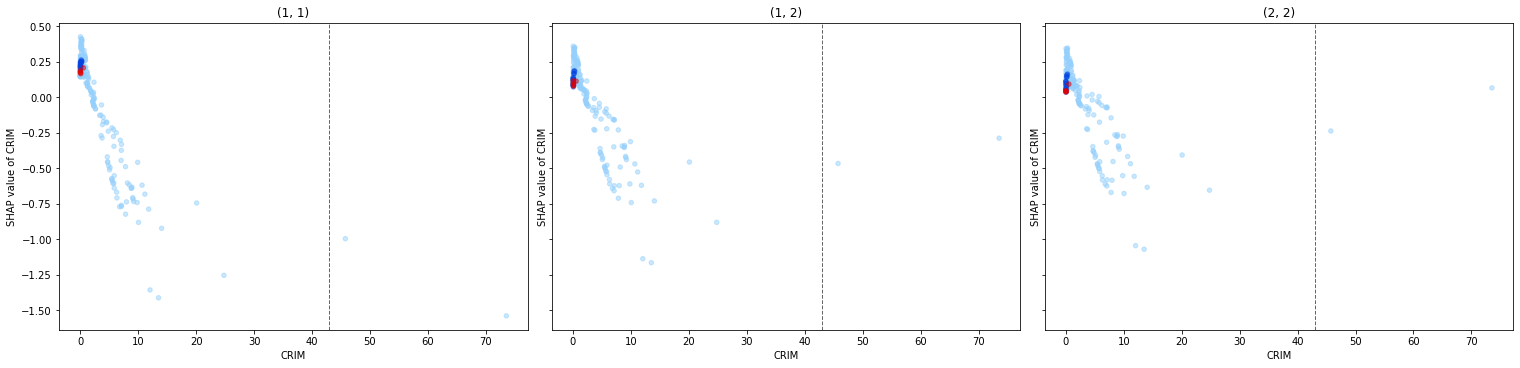

In [64]:
feature = next(feature_it)
plot(feature)

High values tend towards $(2,2)$, where all instances of the difference class flip to it.

AGE <= 1.0
[Upper CF: AGE == 2.0 --> {'(2, 2)': 5}]


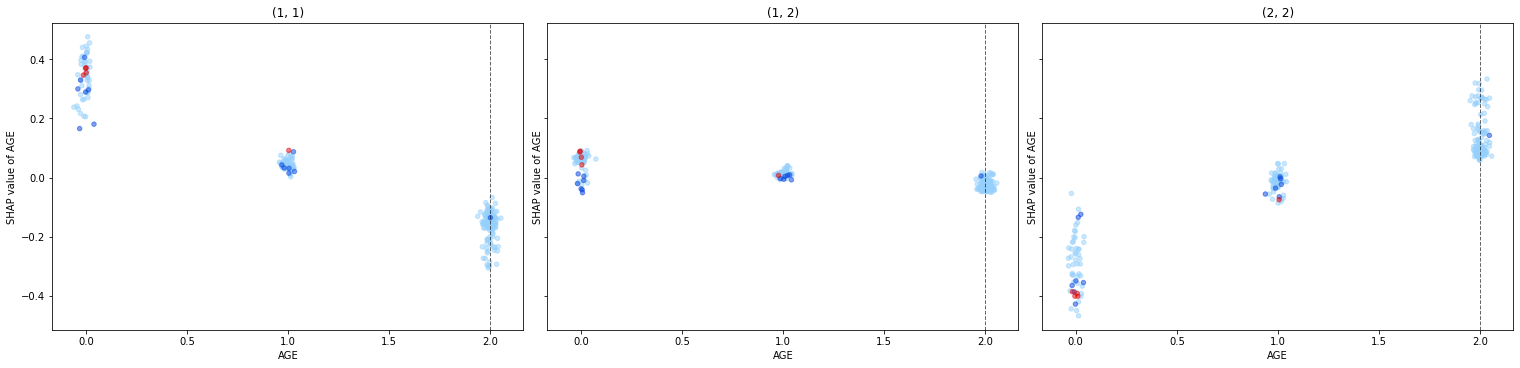

In [65]:
feature = next(feature_it)
plot(feature)

Differences are in the lower half.

RAD <= 5.0
[Upper CF: RAD == 13.36 --> {'(2, 2)': 5}]


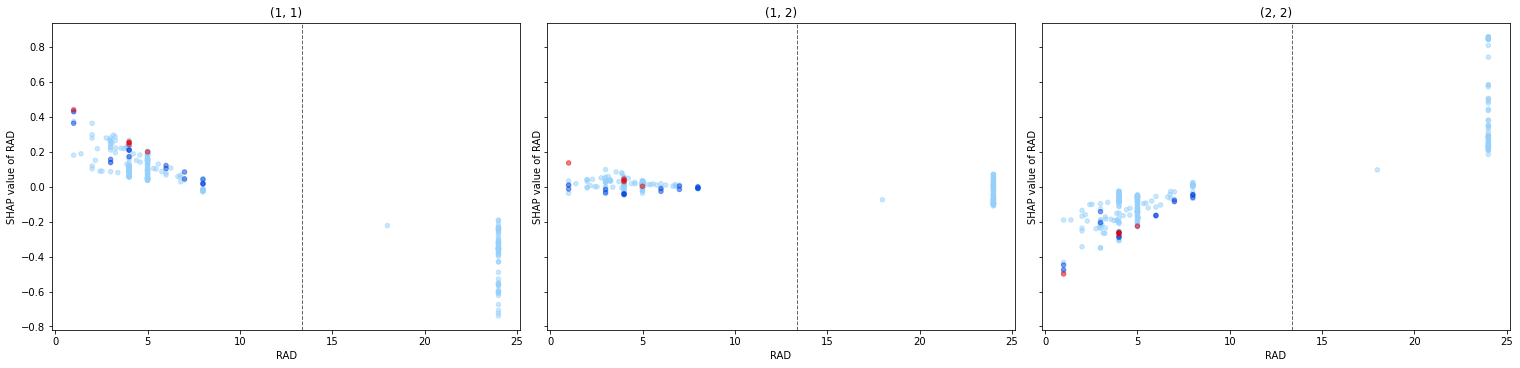

In [66]:
feature = next(feature_it)
plot(feature)

CF outside main distribution.

5.936 <= RM <= 7.225002872141104
[Upper CF: RM == 8.64 --> {'(2, 2)': 5}]


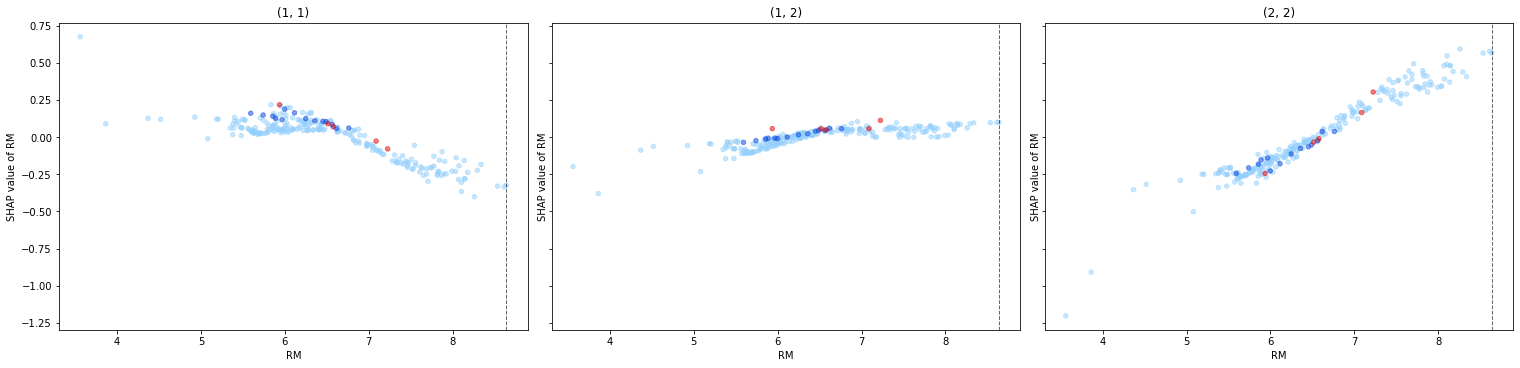

In [67]:
feature = next(feature_it)
plot(feature)

In [68]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('ZN', 'LSTAT', 'INDUS', 'AGE', 'RAD')
print(rule)
node.evaluate_rules(rule)

ZN > 16.0 and 3.58 < LSTAT <= 11.58 and INDUS <= 16.12 and AGE <= 1.0 and RAD <= 13.35
              precision    recall  f1-score   support

       False       1.00      0.36      0.53        14
        True       0.36      1.00      0.53         5

    accuracy                           0.53        19
   macro avg       0.68      0.68      0.53        19
weighted avg       0.83      0.53      0.53        19



In [69]:
explanations_global = [(rule, constraint, instance_indices)]

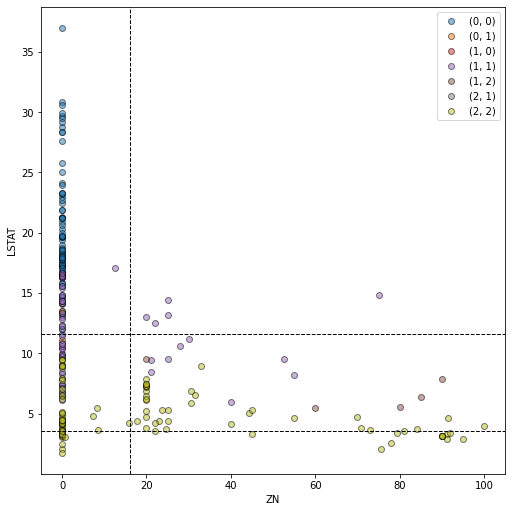

In [70]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Node 1 (RRLL)

In [71]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLL,
 (1, 2)    4
 (1, 1)    1
 dtype: int64,
 2.048332321891543)

Now the distance is much lower.

The instance not classified differently that is most similar is classified $(1,1)$

In [73]:
feature_it = iter(node.features_with_counterfactuals)

Still, ZN is the most important local feature and the counterfactual now much closer to the instances classified differently. Its feature values are on the upper spectrum of the global range. Further, the instance most similar and not classified differently is located just on the other side of the CF.

60.0 <= ZN <= 90.0
[Lower CF: ZN == 53.0 --> {'(1, 1)': 4}]


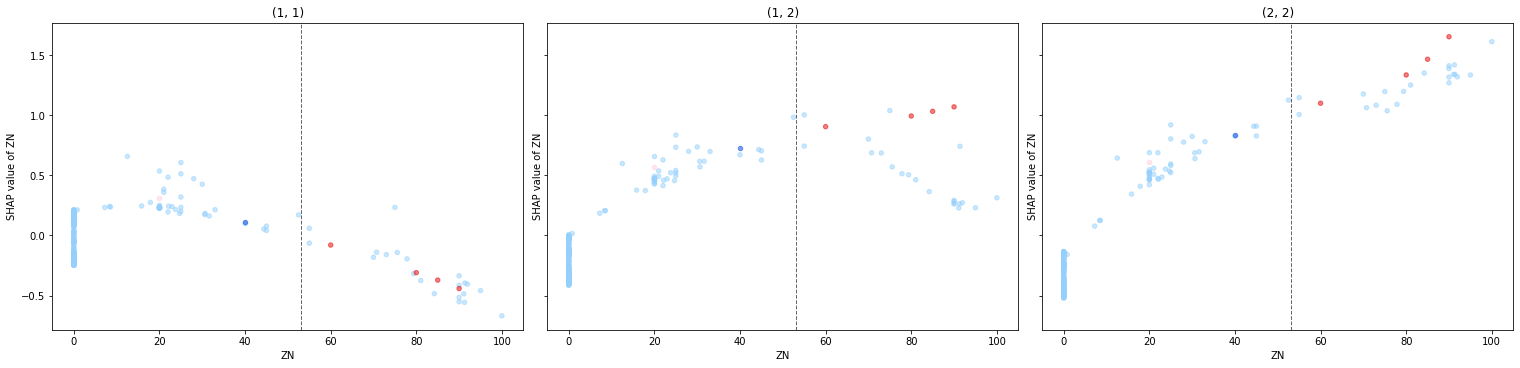

In [74]:
plot(next(feature_it))

Same as parent

5.49 <= LSTAT <= 7.85
[Lower CF: LSTAT == 3.58 --> {'(2, 2)': 4},
 Upper CF: LSTAT == 11.59 --> {'(1, 1)': 4}]


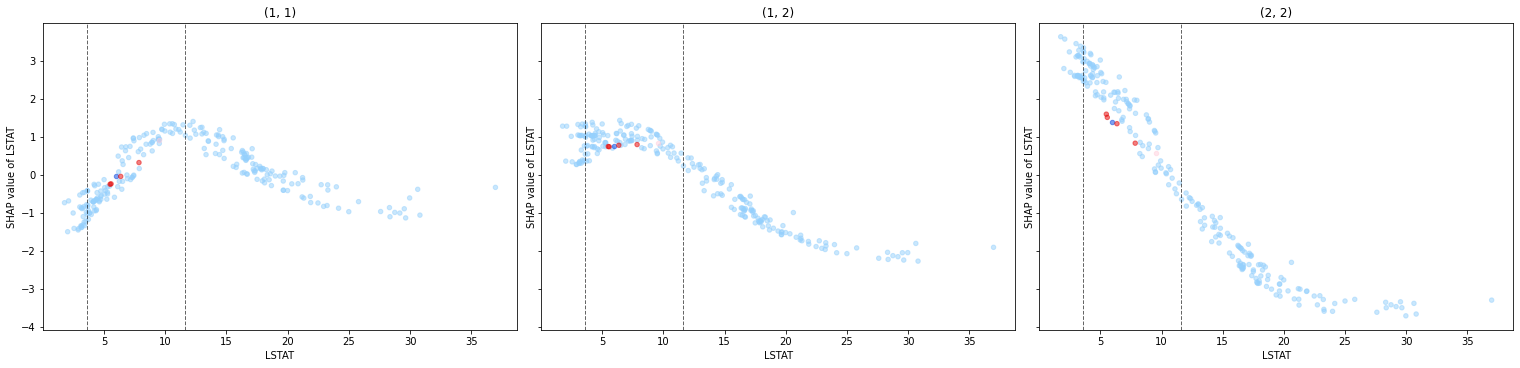

In [75]:
plot(next(feature_it))

Now with CF

7.3073 <= DIS
[Lower CF: DIS == 3.67 --> {'(2, 2)': 4}]


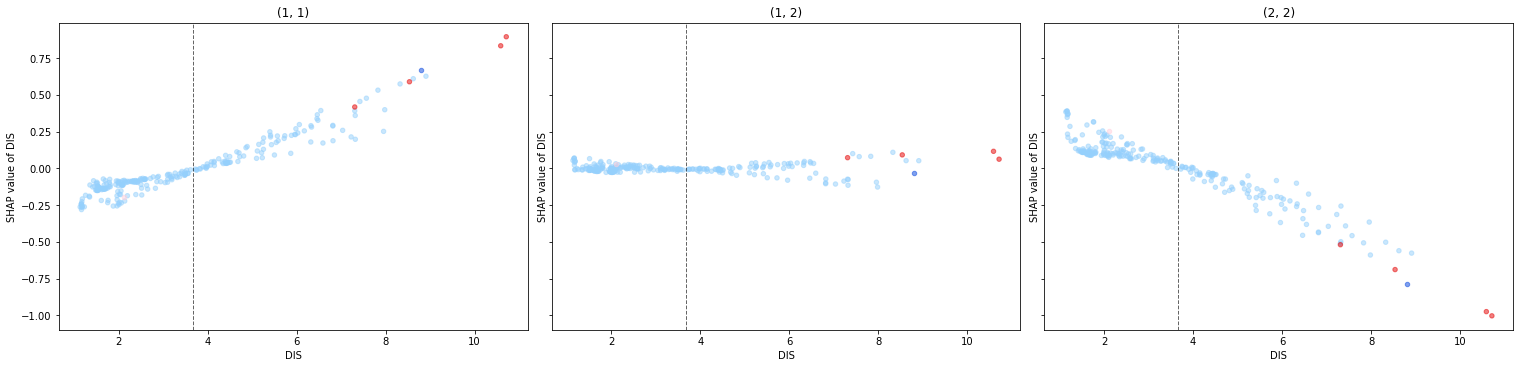

In [76]:
plot(next(feature_it))

In [15]:
part = node.root.filter('3.58 < LSTAT <= 11.58 and ZN >= 53')

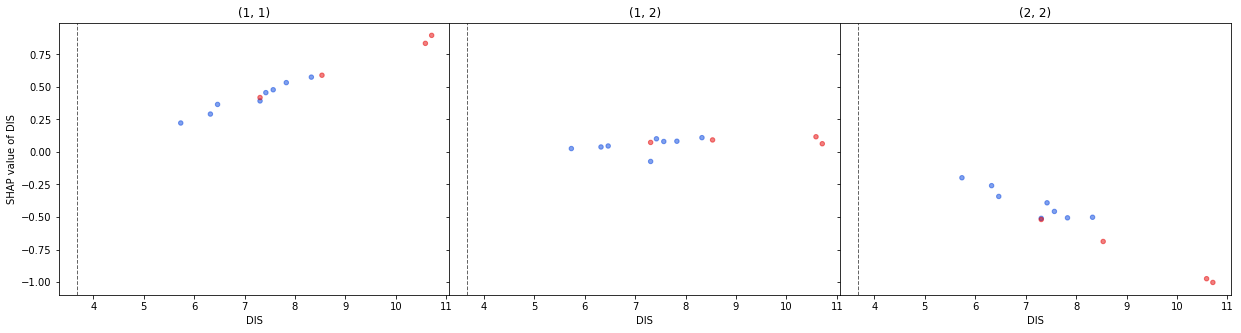

In [18]:
part.plot_feature_dependence('DIS', alpha=0.5)

Same as parent

1.69 <= INDUS <= 4.15
[Upper CF: INDUS == 16.13 --> {'(1, 1)': 4}]


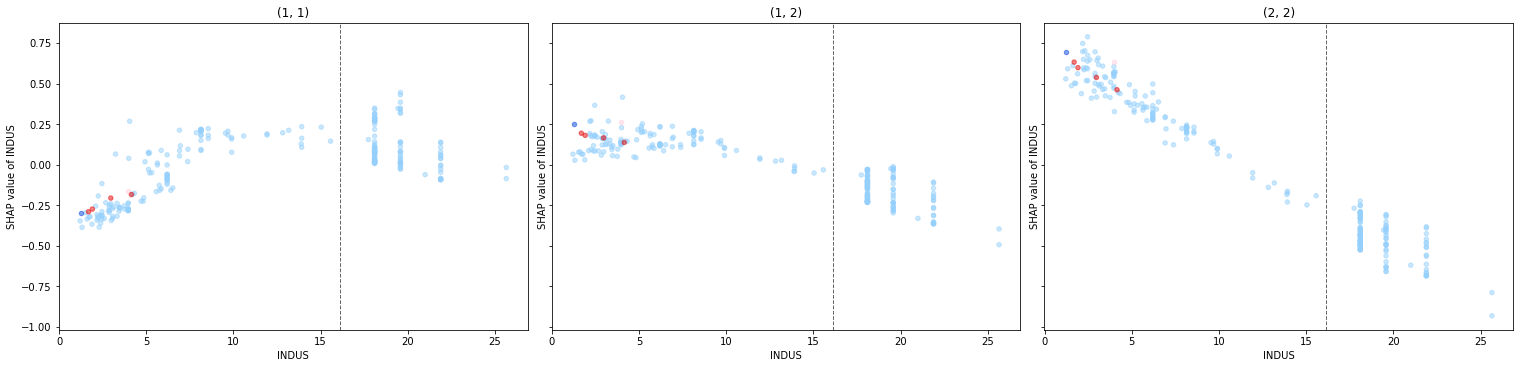

In [77]:
plot(next(feature_it))

Same as parent

AGE == 0.0
[Upper CF: AGE == 2.0 --> {'(2, 2)': 4}]


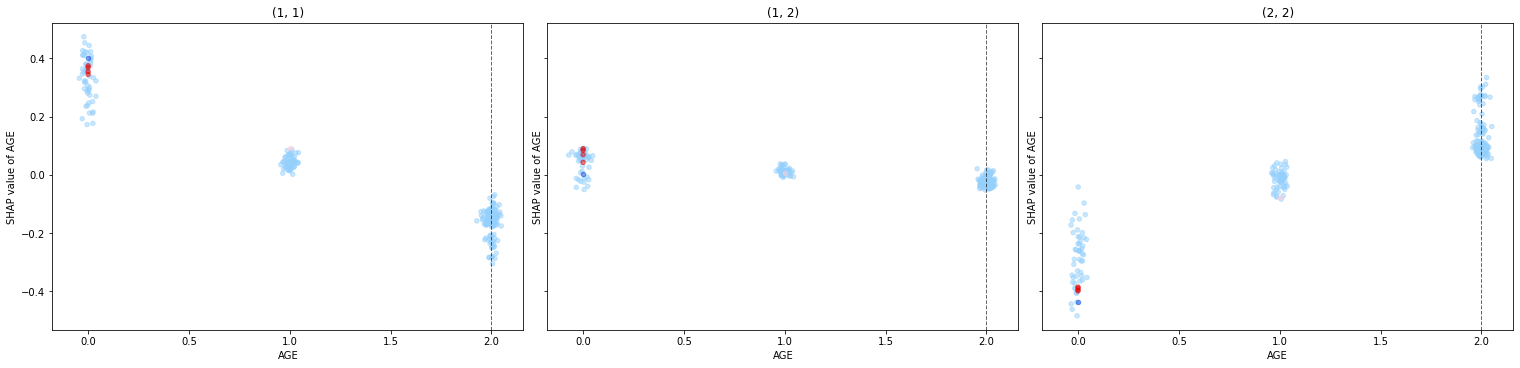

In [78]:
plot(next(feature_it))

Same as parent

RAD <= 4.0
[Upper CF: RAD == 13.36 --> {'(2, 2)': 4}]


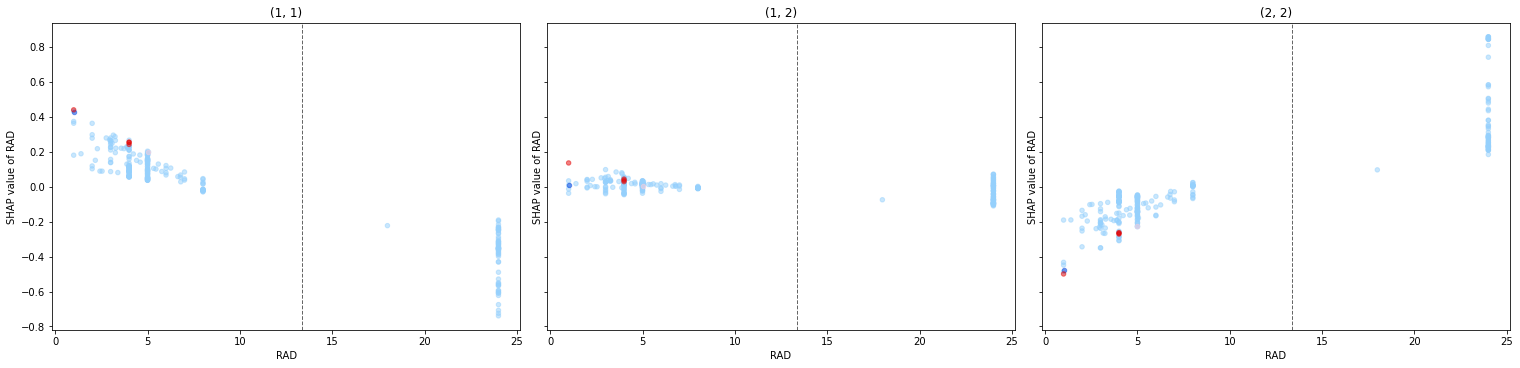

In [79]:
plot(next(feature_it))

CF outside main distribution

CRIM <= 0.10659
[Upper CF: CRIM == 43.0 --> {'(2, 2)': 3, '(1, 0)': 1}]


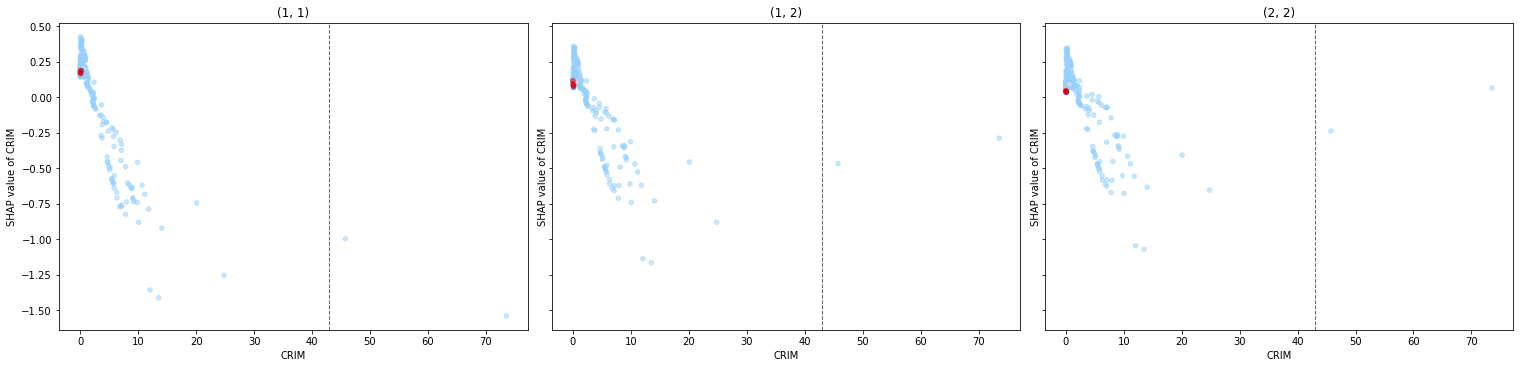

In [80]:
plot(next(feature_it))

CF outside main distribution

5.936 <= RM <= 7.088
[Upper CF: RM == 8.64 --> {'(2, 2)': 4}]


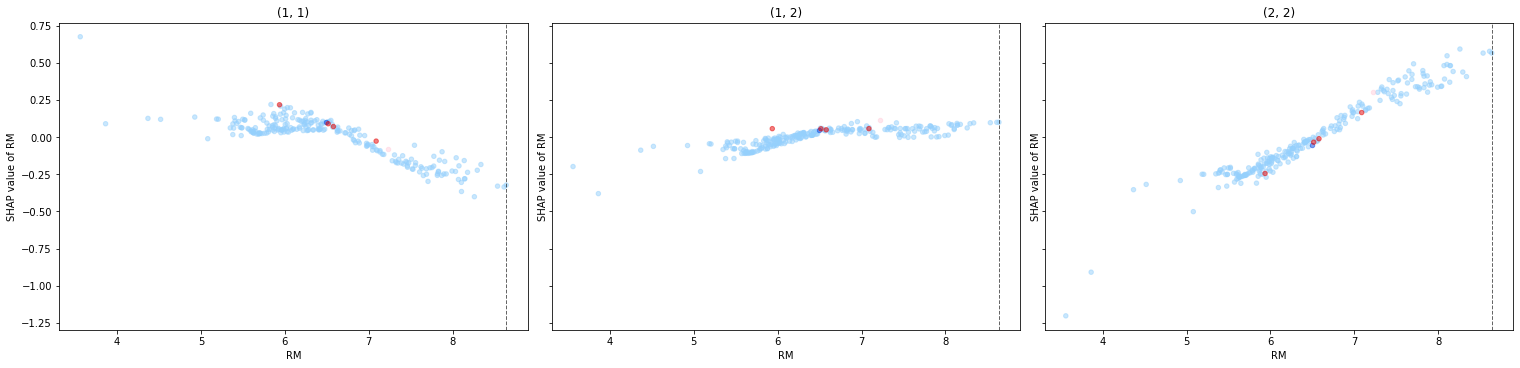

In [81]:
plot(next(feature_it))

In [83]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('ZN', 'LSTAT', 'DIS', 'INDUS', 'AGE', 'RAD')
print(rule)
node.evaluate_rules(rule)

ZN > 53.0 and 3.58 < LSTAT <= 11.58 and DIS > 3.67 and INDUS <= 16.12 and AGE <= 1.0 and RAD <= 13.35
              precision    recall  f1-score   support

       False       1.00      1.00      1.00         1
        True       1.00      1.00      1.00         4

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



In [84]:
explanations_l1 = [(rule, constraint, instance_indices)]

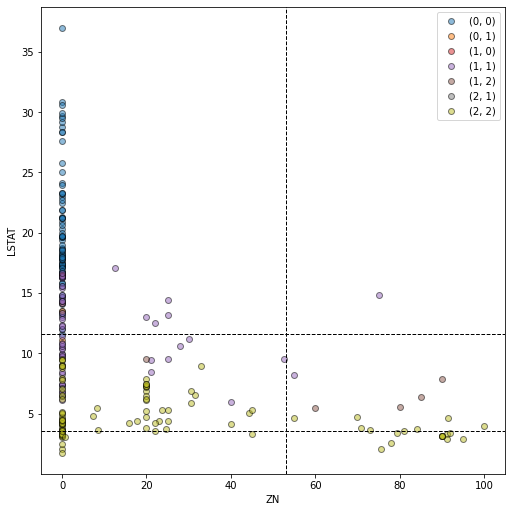

In [85]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Node 2 (RRLRLLL)

In [86]:
node = node.root.get('RRLR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLRLLL,
 (1, 2)    1
 dtype: int64,
 0)

The instance most similar is classified $(2,2)$.

In [88]:
feature_it = iter(node.features_with_counterfactuals)

The main difference to the comparison instance seems to be LSTAT. CFs are close to the instance classified differently. Comparison instance is on the side where $(2,2)$ increases.

LSTAT == 9.522242201272585
[Lower CF: LSTAT == 9.44 --> {'(2, 2)': 1},
 Upper CF: LSTAT == 9.79 --> {'(1, 1)': 1}]


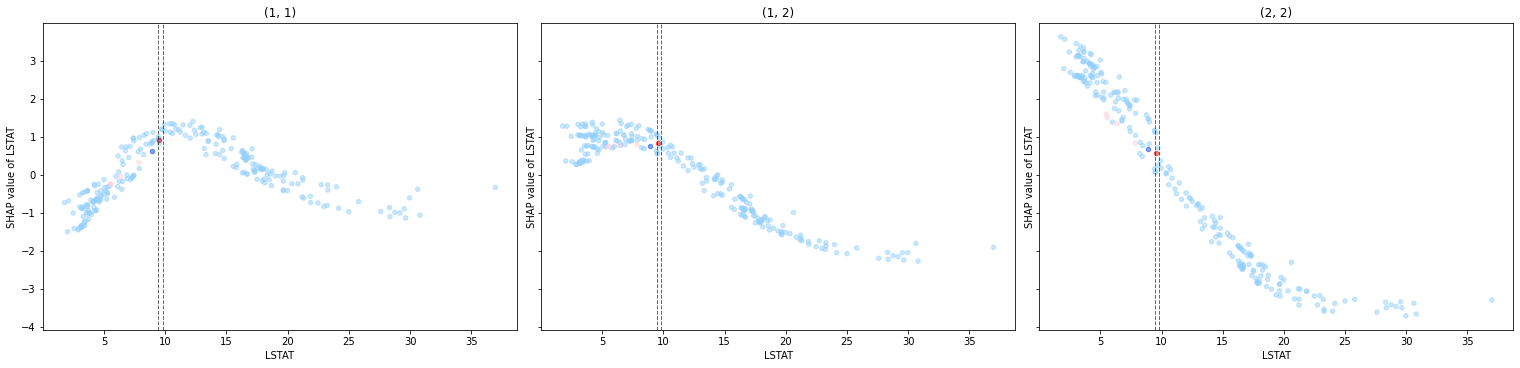

In [89]:
plot(next(feature_it))

For this instance, ZN is much lower than for the sibling cluster. Further, it also has an upper counterfactual. Comparison instance is on the side where $(2,2)$ increases.

ZN == 20.0
[Lower CF: ZN == 16.0 --> {'(1, 1)': 1}, Upper CF: ZN == 26.0 --> {'(2, 2)': 1}]


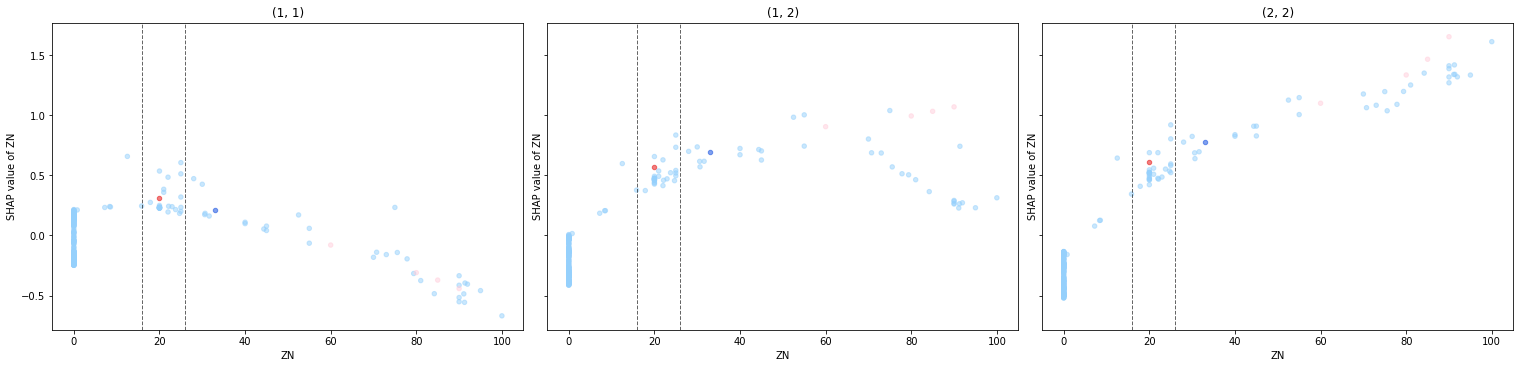

In [90]:
plot(next(feature_it))

INDUS is also lower, with close CFs. Comparison instance is on the side where $(2,2)$ increases.

INDUS == 3.97
[Lower CF: INDUS == 3.54 --> {'(2, 2)': 1},
 Upper CF: INDUS == 5.02 --> {'(1, 1)': 1}]


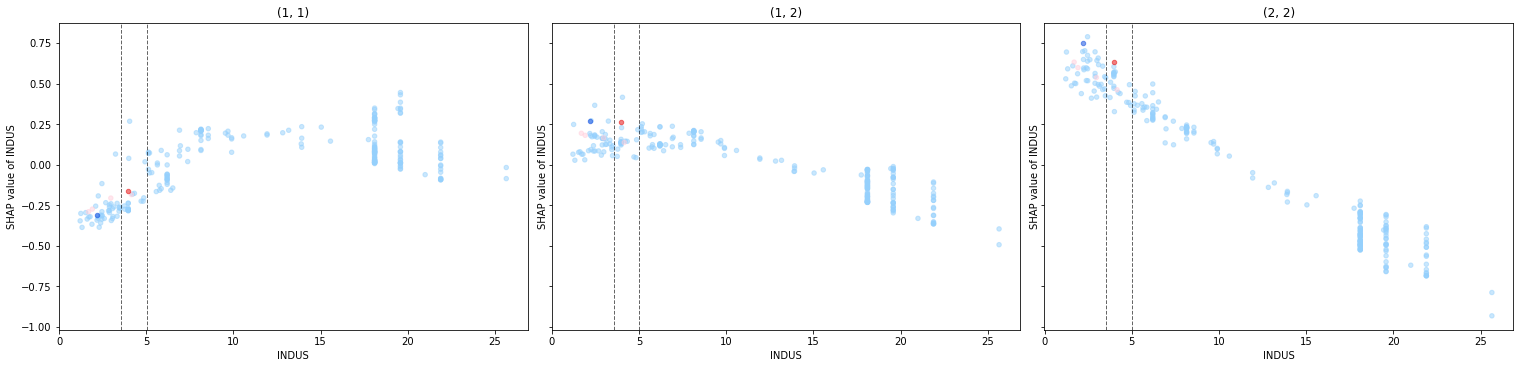

In [91]:
plot(next(feature_it))

I'm not analyzing more features, because I've already seen three strong reasons why this instance was classified differently.

In [92]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'ZN', 'INDUS', 'AGE', 'RAD')
print(rule)
node.evaluate_rules(rule)

9.44 < LSTAT <= 9.78 and 16.0 < ZN <= 25.0 and 3.54 < INDUS <= 5.01 and 3.81 < RAD <= 5.38 and 0.0 < AGE <= 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00         1
        True       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [93]:
explanations_l1.append((rule, constraint, instance_indices))

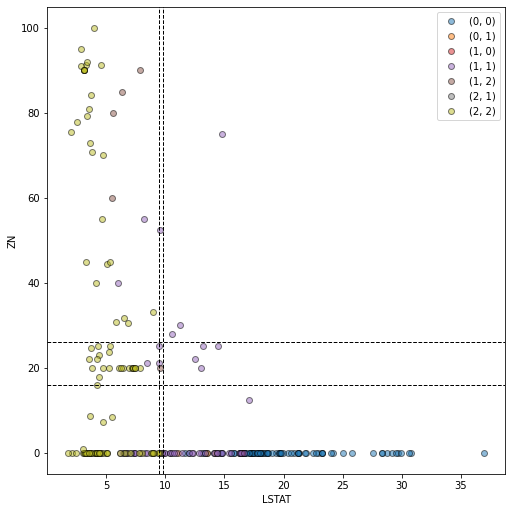

In [94]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Evaluation

#### Global Fidelity

##### Global

In [95]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [96]:
print_rules(rules)
node.root.evaluate_rules(*rules)

1. ZN > 16.0 and 3.58 < LSTAT <= 11.58 and INDUS <= 16.12 and AGE <= 1.0 and RAD <= 13.35
              precision    recall  f1-score   support

       False       1.00      0.86      0.92       241
        True       0.13      1.00      0.23         5

    accuracy                           0.86       246
   macro avg       0.56      0.93      0.58       246
weighted avg       0.98      0.86      0.91       246



##### Level 1

In [97]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [98]:
print_rules(rules)
node.root.evaluate_rules(*rules)

1. ZN > 53.0 and 3.58 < LSTAT <= 11.58 and DIS > 3.67 and INDUS <= 16.12 and AGE <= 1.0 and RAD <= 13.35
2. 9.44 < LSTAT <= 9.78 and 16.0 < ZN <= 25.0 and 3.54 < INDUS <= 5.01 and 3.81 < RAD <= 5.38 and 0.0 < AGE <= 1.0
              precision    recall  f1-score   support

       False       1.00      0.97      0.98       241
        True       0.38      1.00      0.56         5

    accuracy                           0.97       246
   macro avg       0.69      0.98      0.77       246
weighted avg       0.99      0.97      0.97       246



#### Counterfactual Fidelity Error

##### Global

In [99]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [100]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [101]:
rmse

CRIM             NaN
ZN         34.449964
INDUS       7.952371
NOX              NaN
RM               NaN
AGE         0.000000
DIS              NaN
RAD         4.567343
TAX              NaN
PTRATIO          NaN
LSTAT       3.015269
dtype: float64

In [102]:
boundary_miss_rate

CRIM       1.000000
ZN         0.166667
INDUS      0.166667
NOX        1.000000
RM         1.000000
AGE        0.166667
DIS        1.000000
RAD        0.166667
TAX        1.000000
PTRATIO         NaN
LSTAT      0.000000
dtype: float64

In [103]:
boundary_add_rate

CRIM       NaN
ZN         0.0
INDUS      0.0
NOX        NaN
RM         NaN
AGE        0.0
DIS        NaN
RAD        0.0
TAX        NaN
PTRATIO    NaN
LSTAT      0.0
dtype: float64

##### Level 1

In [104]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [105]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [106]:
rmse

CRIM            NaN
ZN         1.527525
INDUS      5.668170
NOX             NaN
RM              NaN
AGE        0.000000
DIS        2.344552
RAD        2.607112
TAX             NaN
PTRATIO         NaN
LSTAT      2.309522
dtype: float64

In [107]:
boundary_miss_rate

CRIM       1.000000
ZN         0.000000
INDUS      0.000000
NOX        1.000000
RM         1.000000
AGE        0.000000
DIS        0.333333
RAD        0.000000
TAX        1.000000
PTRATIO         NaN
LSTAT      0.000000
dtype: float64

In [108]:
boundary_add_rate

CRIM       NaN
ZN         0.0
INDUS      0.0
NOX        NaN
RM         NaN
AGE        0.0
DIS        0.0
RAD        0.0
TAX        NaN
PTRATIO    NaN
LSTAT      0.0
dtype: float64

#### Complexity

##### Global

In [109]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

##### Level 1

In [111]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [112]:
get_complexity(constraints)

Number of rules: 2
Number of constraints: 17 (8.5 per rule)


## Clustering of Class $(2,1)$ SHAP Values

In [22]:
focus_class = '(2, 1)'

In [27]:
%%time
node = make_clustering(comparer, diffclf_shap_values,
                       focus_class, ['(1, 1)', '(2, 1)', '(2, 2)'],
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions)
with open(f'clustering.{focus_class}.pickle', 'wb') as f:
    pickle.dump(node, f)
node, node.class_counts, node.distance

CPU times: user 4.09 s, sys: 49.6 ms, total: 4.14 s
Wall time: 4.29 s


(root,
 (2, 2)    96
 (0, 0)    86
 (1, 1)    52
 (1, 2)     5
 (0, 1)     3
 (1, 0)     2
 (2, 1)     2
 dtype: int64,
 67.49967166699163)

In [28]:
with open(f'clustering.{focus_class}.pickle', 'rb') as f:
    node = pickle.load(f)
with open(f'ground_truth.{node.diff_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

### Main Node (LRL)

In [29]:
node = node.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LRL,
 (2, 2)    11
 (2, 1)     2
 (1, 1)     2
 dtype: int64,
 6.667651204980361)

The distance of the main cluster containing the differences is low, the global explanation might be sufficient.

In [30]:
feature_it = iter(node.features_with_counterfactuals)

Narrow LSTAT range

6.48 <= LSTAT <= 7.12
[Lower CF: LSTAT == 6.05 --> {'(2, 2)': 2},
 Upper CF: LSTAT == 7.42 --> {'(1, 1)': 2}]


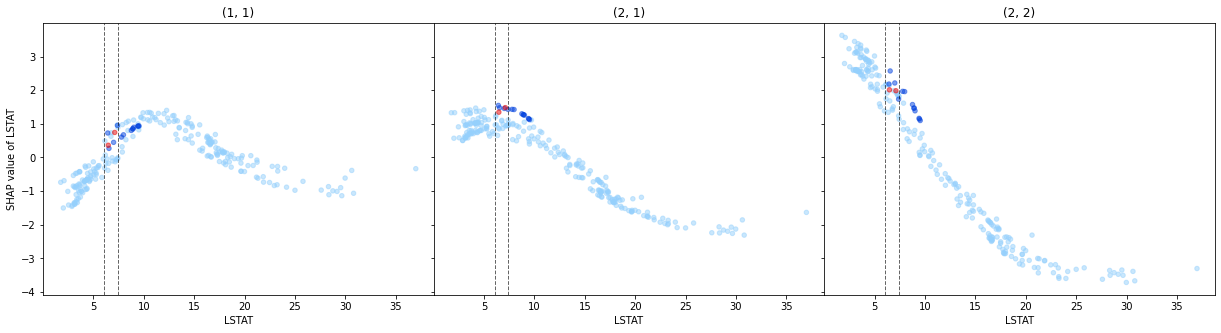

In [31]:
plot(next(feature_it))

CFs outside main distribution

0.10959 <= CRIM <= 4.55587
[Upper CF: CRIM == 8.7 --> {'(2, 2)': 1, '(2, 0)': 1}]


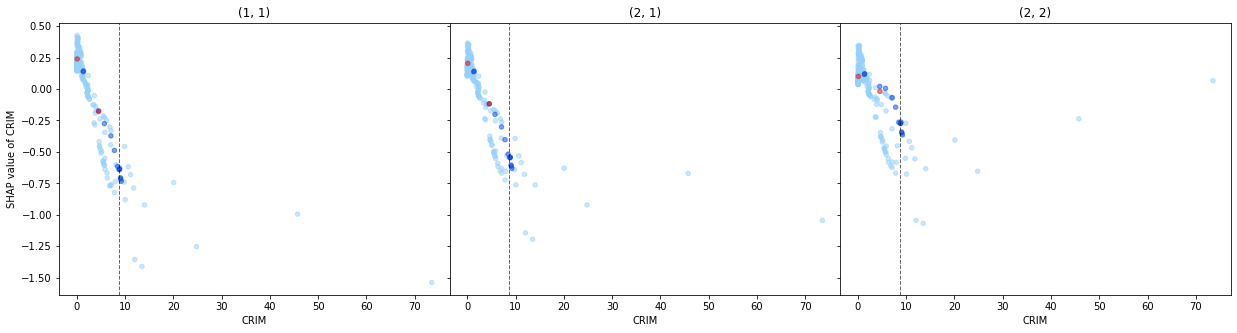

In [32]:
plot(next(feature_it))

Mid-range INDUS values, where both $(2,2)$ and $(1,1)$ aren't too high.

11.93 <= INDUS <= 18.1
[Lower CF: INDUS == 9.8 --> {'(2, 2)': 2},
 Upper CF: INDUS == 19.62 --> {'(1, 1)': 2}]


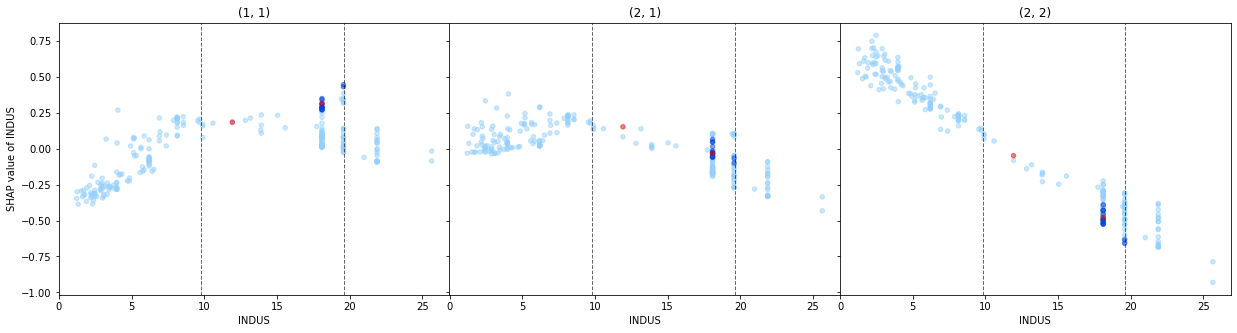

In [33]:
plot(next(feature_it))

Low ZN values.

ZN == 0.0
[Upper CF: ZN == 19.0 --> {'(2, 2)': 2}]


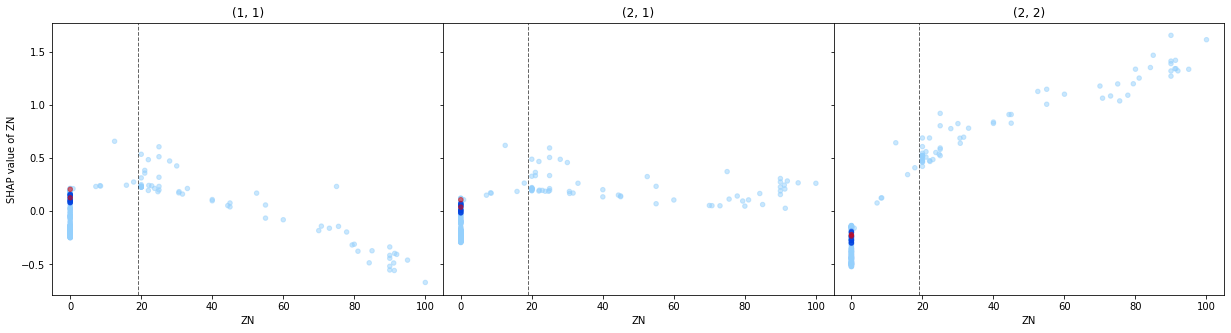

In [34]:
plot(next(feature_it))

DIS in lower part, where $(2,2)$ is highest and $(2,1)$ is high, but to a lower extent.

1.6132 <= DIS <= 2.3889
[Upper CF: DIS == 4.18 --> {'(1, 1)': 2}]


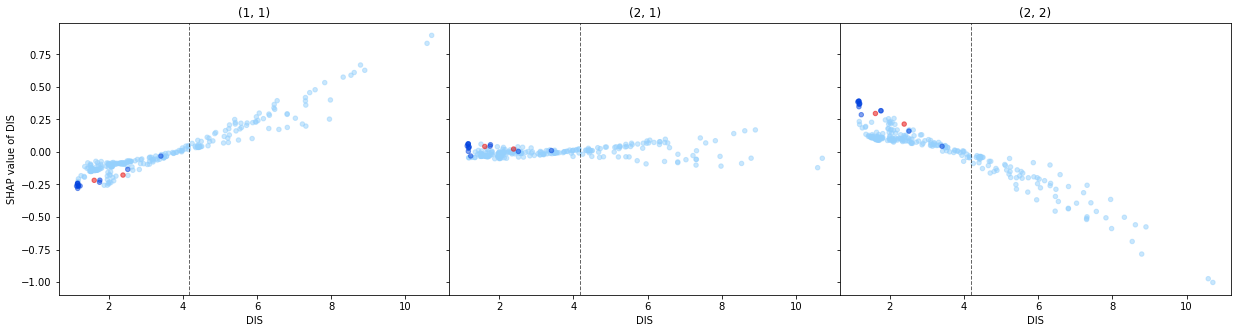

In [35]:
plot(next(feature_it))

One of the two is an outlier in terms of RM. I'll investigate on a lower cluster level.

RM <= 6.794
[Upper CF: RM == 7.18 --> {'(2, 2)': 2}]


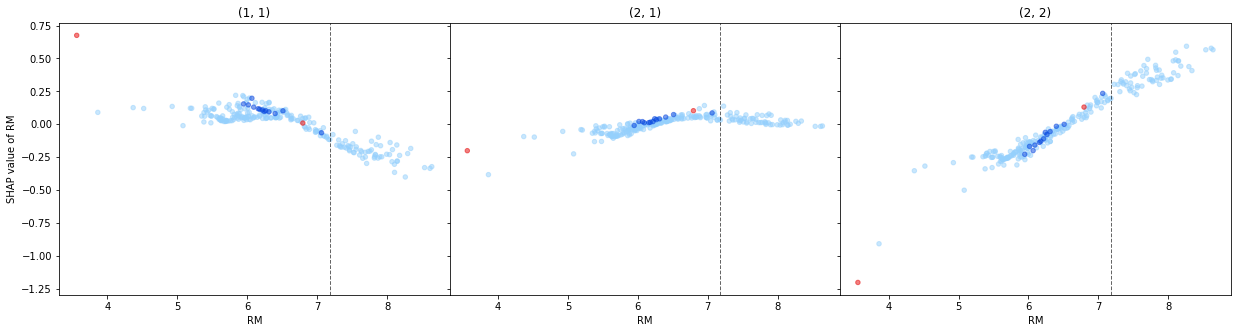

In [36]:
plot(next(feature_it))

They easily flip to $(1,1)$ when decreasing AGE by 1.

AGE == 2.0
[Lower CF: AGE == 1.0 --> {'(1, 1)': 2}]


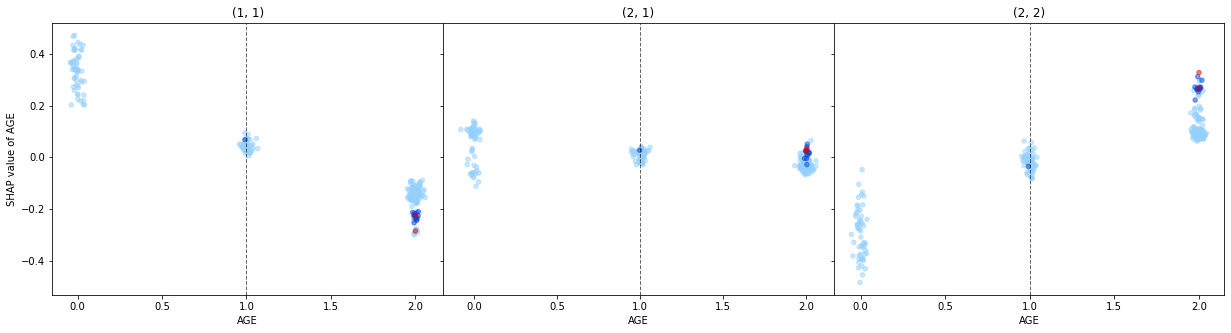

In [37]:
plot(next(feature_it))

In [38]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'INDUS', 'ZN', 'DIS', 'AGE')
print(rule)
node.evaluate_rules(rule)

6.05 < LSTAT <= 7.41 and 9.8 < INDUS <= 19.61 and ZN <= 18.0 and DIS <= 4.17 and AGE > 1.0


IndexError: index 101 is out of bounds for axis 0 with size 15

In [ ]:
explanations_global = [(rule, constraint, instance_indices)]

In [ ]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Node 1 (LRLLL)

In [39]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LRLLL,
 (2, 1)    1
 dtype: int64,
 0)

In [45]:
node.instance_indices

array([101])

The instances most similar are classified $(1,1)$, even though the difference to $(2,2)$ is less.

In [40]:
feature_it = iter(node.features_with_counterfactuals)

Upper CF is a bit lower, so that it includes one of the comparison instances.

LSTAT == 6.48
[Lower CF: LSTAT == 6.05 --> {'(2, 2)': 1},
 Upper CF: LSTAT == 7.32 --> {'(1, 1)': 1}]


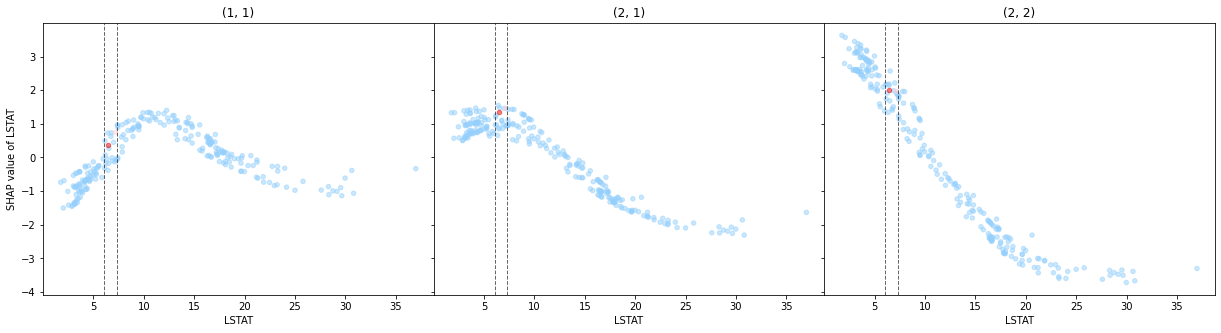

In [41]:
plot(next(feature_it))

RAD clearifies why this instance is classified differently: because of its low value. At 3.24, it flips to $(2,2)$.

RAD == 1.0
[Upper CF: RAD == 3.24 --> {'(2, 2)': 1}]


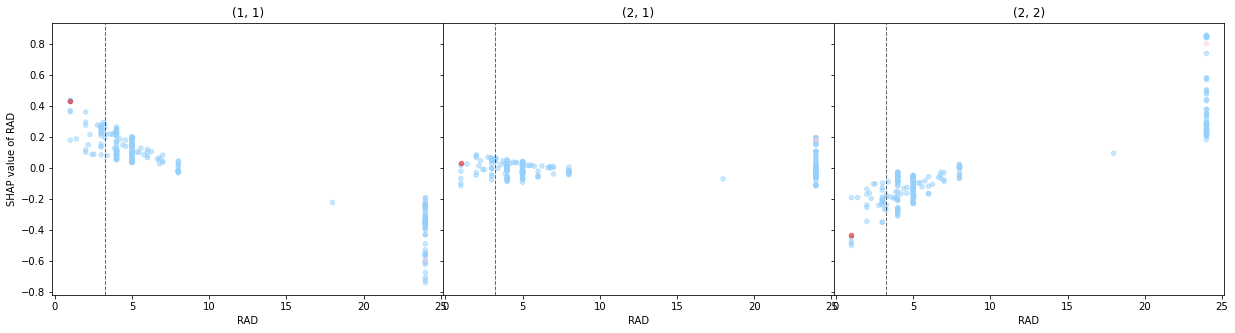

In [42]:
plot(next(feature_it))

Same as parent.

AGE == 2.0
[Lower CF: AGE == 1.0 --> {'(1, 1)': 1}]


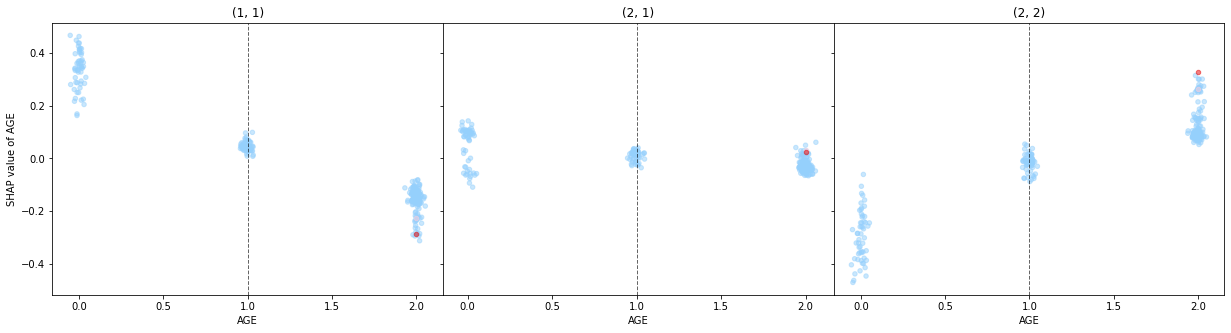

In [43]:
plot(next(feature_it))

CRIM == 0.10959
[Upper CF: CRIM == 2.3 --> {'(2, 2)': 1}]


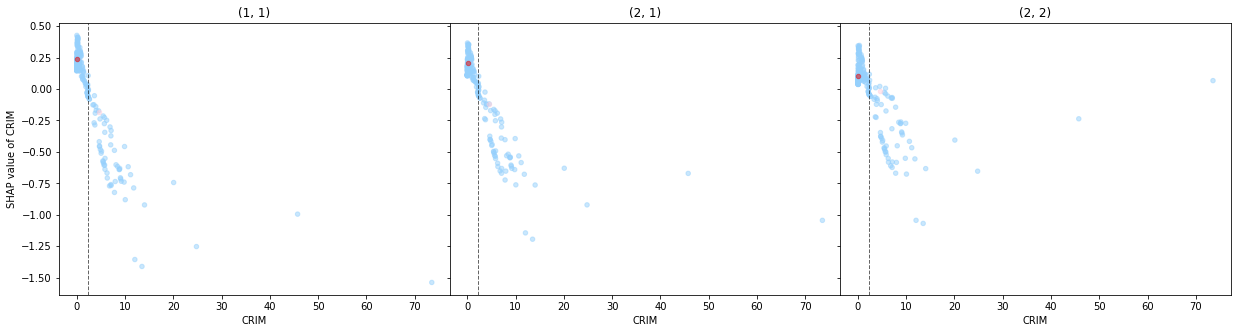

In [44]:
plot(next(feature_it))

In [135]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'RAD', 'INDUS', 'ZN', 'DIS', 'AGE')
print(rule)
node.evaluate_rules(rule)

6.05 < LSTAT <= 7.31 and 9.8 < INDUS <= 16.31 and AGE > 1.0 and ZN <= 6.0 and RAD <= 3.23 and 1.44 < DIS <= 4.17
              precision    recall  f1-score   support

       False       1.00      1.00      1.00         2
        True       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



In [136]:
explanations_l1 = [(rule, constraint, instance_indices)]

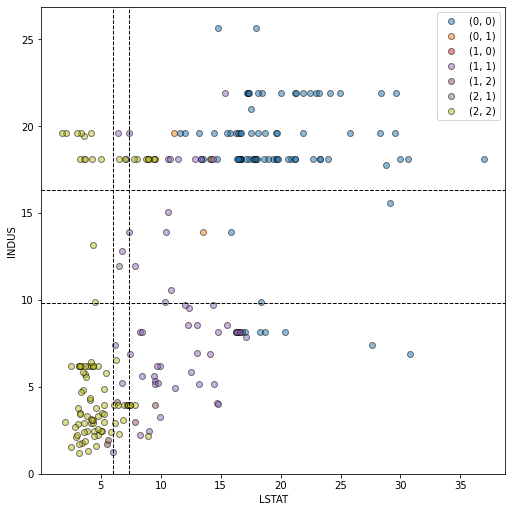

In [137]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Node 2 (LRLRRL)

In [46]:
node = node.root.get('LRLR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LRLRRL,
 (2, 1)    1
 dtype: int64,
 0)

In [66]:
node.shap_values[0, :, '(2, 1)']

.values =
array([-0.11788812,  0.03947136, -0.03201015,  0.00692424, -0.20124016,
        0.03238018,  0.04203929,  0.18105823,  0.25395641,  0.0733404 ,
        1.48073687])

.base_values =
-2.9111803029992793

.data =
array([  4.55587,   0.     ,  18.1    ,   0.718  ,   3.561  ,   2.     ,
         1.6132 ,  24.     , 666.     ,  20.2    ,   7.12   ])

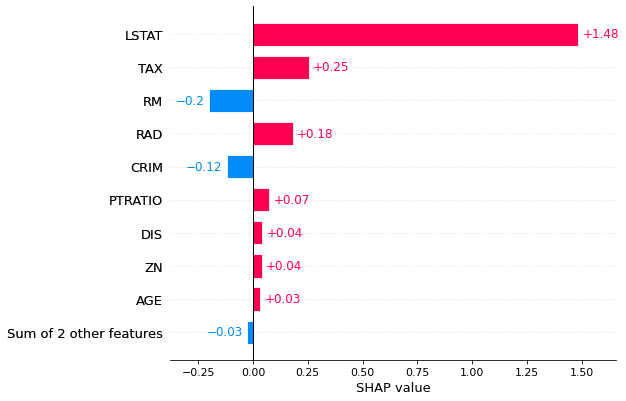

In [67]:
bar(node.shap_values[0, :, '(2, 1)'])

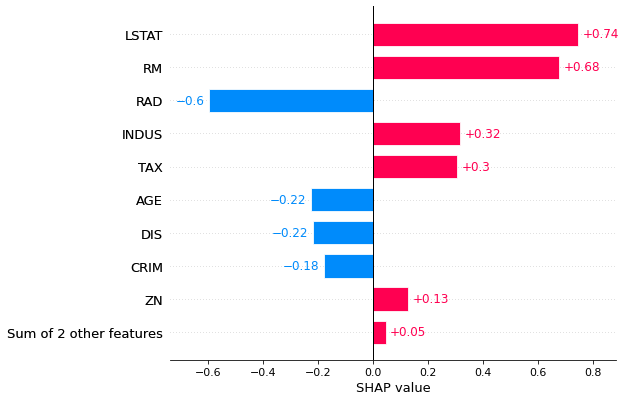

In [68]:
bar(node.shap_values[0, :, '(1, 1)'])

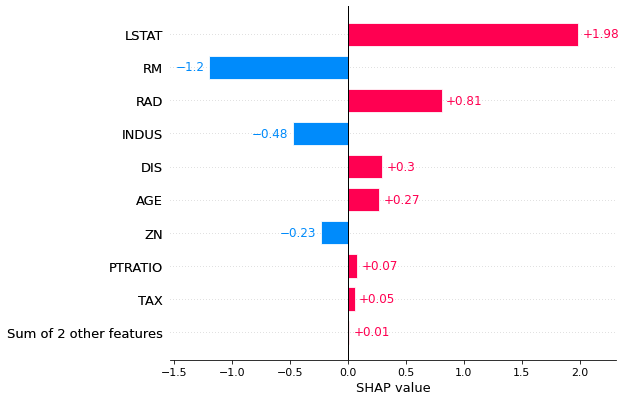

In [69]:
bar(node.shap_values[0, :, '(2, 2)'])

In [47]:
node.instance_indices

array([34])

The four most similar instances are classified $(2,2)$. Nevertheless, the difference to the log odds outcome of $(1,1)$ is less than to $(2,2)$.

In [70]:
feature_it = iter(node.features_with_counterfactuals)

CFs nearly identical.

LSTAT == 7.12
[Lower CF: LSTAT == 6.06 --> {'(2, 2)': 1},
 Upper CF: LSTAT == 7.42 --> {'(1, 1)': 1}]


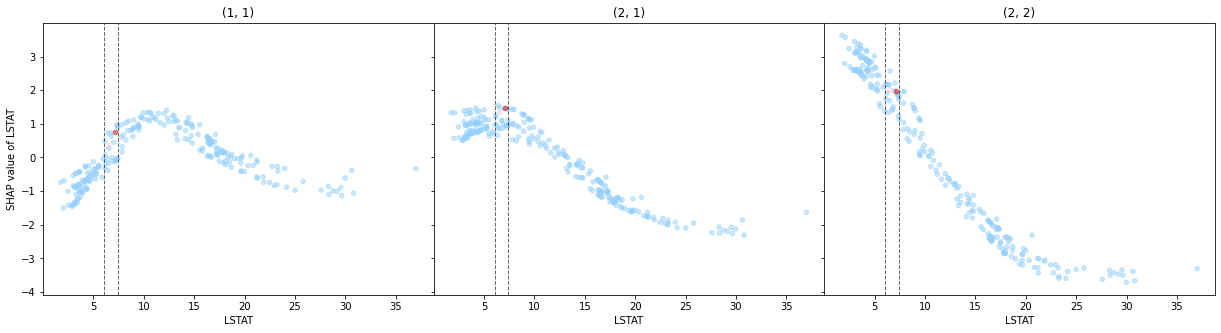

In [71]:
plot(next(feature_it))

This instance is the outlier. This seems to be the main characteristic of it.

RM == 3.561
[Upper CF: RM == 4.54 --> {'(2, 2)': 1}]


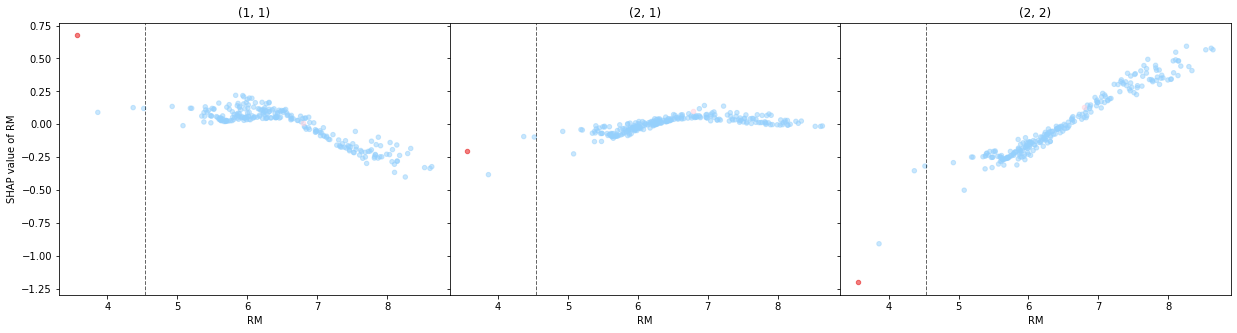

In [72]:
plot(next(feature_it))

RAD == 24.0
[Lower CF: RAD == 22.57 --> {'(1, 1)': 1}]


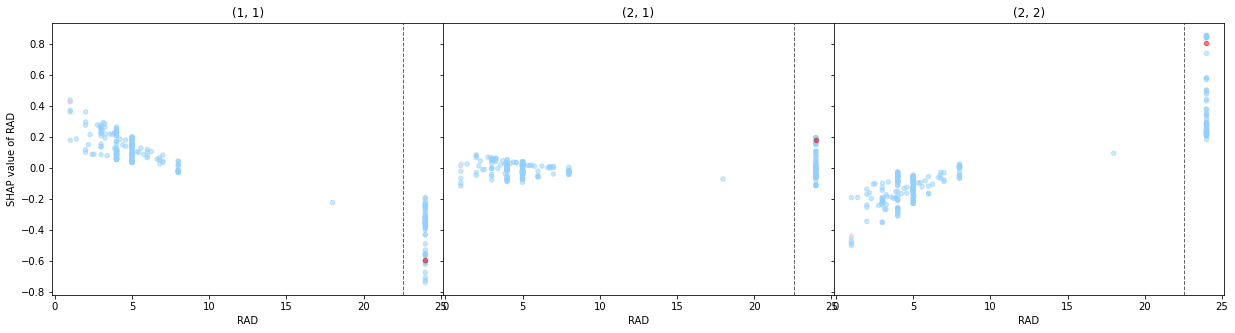

In [75]:
plot(next(feature_it))

CRIM == 4.55587
[Lower CF: CRIM == 0.3 --> {'(1, 1)': 1},
 Upper CF: CRIM == 8.7 --> {'(2, 0)': 1}]


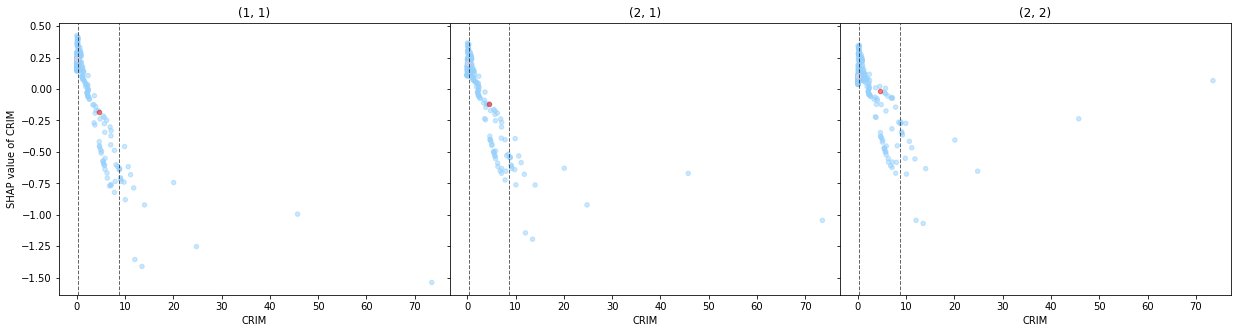

In [73]:
plot('CRIM')

In [74]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'RM', 'INDUS', 'ZN', 'DIS', 'AGE')
print(rule)
node.evaluate_rules(rule)

6.06 < LSTAT <= 7.41 and RM <= 4.53 and 10.73 < INDUS <= 19.61 and ZN <= 18.0 and DIS <= 2.24 and AGE > 1.0


IndexError: index 34 is out of bounds for axis 0 with size 1

In [144]:
explanations_l1.append((rule, constraint, instance_indices))

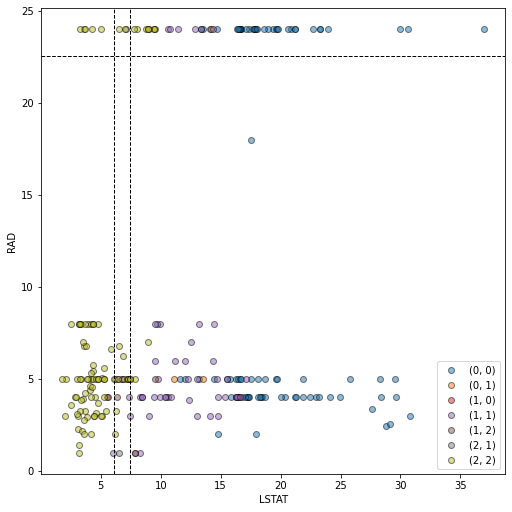

In [145]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Evaluation

#### Global Fidelity

##### Global

In [146]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [147]:
print_rules(rules)
node.root.evaluate_rules(*rules)

1. 6.05 < LSTAT <= 7.41 and 9.8 < INDUS <= 19.61 and ZN <= 18.0 and DIS <= 4.17 and AGE > 1.0
              precision    recall  f1-score   support

       False       1.00      0.99      0.99       244
        True       0.40      1.00      0.57         2

    accuracy                           0.99       246
   macro avg       0.70      0.99      0.78       246
weighted avg       1.00      0.99      0.99       246



##### Level 1

In [148]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [149]:
print_rules(rules)
node.root.evaluate_rules(*rules)

1. 6.05 < LSTAT <= 7.31 and 9.8 < INDUS <= 16.31 and AGE > 1.0 and ZN <= 6.0 and RAD <= 3.23 and 1.44 < DIS <= 4.17
2. 6.06 < LSTAT <= 7.41 and 10.73 < INDUS <= 19.61 and RM <= 4.53 and ZN <= 18.0 and DIS <= 2.24 and AGE > 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       244
        True       1.00      1.00      1.00         2

    accuracy                           1.00       246
   macro avg       1.00      1.00      1.00       246
weighted avg       1.00      1.00      1.00       246



#### Counterfactual Fidelity Error

##### Global

In [150]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [151]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [152]:
rmse

CRIM            NaN
ZN         8.485281
INDUS      1.714271
NOX             NaN
RM              NaN
AGE        0.000000
DIS        1.364716
RAD             NaN
TAX             NaN
PTRATIO         NaN
LSTAT      0.050249
dtype: float64

In [153]:
boundary_miss_rate

CRIM       1.000000
ZN         0.000000
INDUS      0.000000
NOX             NaN
RM         1.000000
AGE        0.000000
DIS        0.333333
RAD        1.000000
TAX        1.000000
PTRATIO    1.000000
LSTAT      0.000000
dtype: float64

In [154]:
boundary_add_rate

CRIM       NaN
ZN         0.0
INDUS      0.0
NOX        NaN
RM         NaN
AGE        0.0
DIS        0.0
RAD        NaN
TAX        NaN
PTRATIO    NaN
LSTAT      0.0
dtype: float64

##### Level 1

In [155]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [156]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [157]:
rmse

CRIM       NaN
ZN         0.0
INDUS      0.0
NOX        NaN
RM         0.0
AGE        0.0
DIS        0.0
RAD        0.0
TAX        NaN
PTRATIO    NaN
LSTAT      0.0
dtype: float64

In [158]:
boundary_miss_rate

CRIM       1.000000
ZN         0.000000
INDUS      0.000000
NOX             NaN
RM         0.666667
AGE        0.000000
DIS        0.000000
RAD        0.500000
TAX        1.000000
PTRATIO    1.000000
LSTAT      0.000000
dtype: float64

In [159]:
boundary_add_rate

CRIM       NaN
ZN         0.0
INDUS      0.0
NOX        NaN
RM         0.0
AGE        0.0
DIS        0.0
RAD        0.0
TAX        NaN
PTRATIO    NaN
LSTAT      0.0
dtype: float64

#### Complexity

##### Global

In [160]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [161]:
get_complexity(constraints)

Number of rules: 1
Number of constraints: 7 (7.0 per rule)


##### Level 1

In [162]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [163]:
get_complexity(constraints)

Number of rules: 2
Number of constraints: 17 (8.5 per rule)


# Summary

## Fidelity

Ruleset | Precision | Recall | F1
 --- | --- | --- | ---
01/global | 0.27 | 1.0 | 0.43
10/global | 1.0 | 1.0 | 1.0
12/global | 0.13 | 1.0 | 0.23
12/level 1 | 0.38 | 1.0 | 0.56
21/global | 0.4 | 1.0 | 0.57
21/level 1 | 1.0 | 1.0 | 1.0

## Generation Time

Total: approx. 8min
- difference classifier SHAP values generation: 7min 25s
- hierarchical clustering and counterfactuals generation: 36s

## Complexity

Intermediate Results: 43 dependence plots in total

Node | # Dependence Plots
 --- | ---
01/main | 7
10/main | 5
12/main | 8
12/1 | 8
12/2 | 3
21/main | 7
21/1 | 3
21/2 | 2

Final Explanation: As a proxy for the complexity of the final explanation I'm using the rule set derived from the counterfactuals.

Ruleset | # Rules | # Terms
 --- | --- | ---
01/global | 1 | 7
10/global | 1 | 9
12/global | 1 | 6
12/level 1 | 2 | 17
21/global | 1 | 7
21/level 1 | 2 | 17